In [17]:
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Any, Literal
import warnings
import numpy as np
import pandas as pd
import polars as pl
from scipy import stats
import scikit_posthocs as sp
import seaborn as sns


# surpass all future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data_dir = Path('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/5_impact_factors')
rmse = pl.read_csv('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evaluated/before/c_rmse/rmse.csv')
rmse

lab,sample,feature,fgroup,count,rmse
str,str,str,str,i64,f64
"""BS1""","""BC_1""","""compact_beta_bin:compact_depth…","""80–90:4x:-0.1 – 0.0""",254024,17.548689
"""BS1""","""BC_1""","""compact_beta_bin:compact_depth…","""70–80:4x:-0.4 – -0.3""",14919,19.589668
"""BS1""","""BC_1""","""compact_beta_bin:compact_depth…","""0–10:5–10x:0.0 – 0.1""",405395,6.961485
"""BS1""","""BC_1""","""compact_beta_bin:compact_depth…","""40–50:1x:0.1 – 0.2""",823,50.05778
"""BS1""","""BC_1""","""compact_beta_bin:compact_depth…","""50–60:4x:-0.2 – -0.1""",4855,25.198284
…,…,…,…,…,…
"""RR1""","""T4_2""","""compact_beta_bin:compact_depth…","""0–10:1x:0.34–0.36""",48,6.853593
"""RR1""","""T4_2""","""compact_beta_bin:compact_depth…","""20–30:2x:0.02–0.04""",1,76.063662
"""RR1""","""T4_2""","""compact_beta_bin:compact_depth…","""20–30:≥10x:0.1–0.12""",1584,14.026082


In [ ]:
# def calculate_mean_ranks(data, tool_cols, better="smaller"):
#     """
#     计算每个工具的平均秩，并确定优劣顺序
#     :param data: 宽格式DataFrame（样本×工具）
#     :param tool_cols: 工具列名列表
#     :param better: 指标方向 ("smaller"=越小越好, "larger"=越大越好)
#     :return: 平均秩DataFrame + 排序后的工具列表
#     """
#     # 创建秩矩阵（对每个样本内部排名）
#     rank_matrix = data[tool_cols].rank(axis=1, method='average', 
#                                      ascending=(better=="smaller"))
    
#     # 计算每个工具的平均秩
#     mean_ranks = rank_matrix.mean().reset_index()
#     mean_ranks.columns = ['Tool', 'Mean Rank']
    
#     # 按平均秩排序（越小越好 → 升序；越大越好 → 降序）
#     mean_ranks = mean_ranks.sort_values(
#         'Mean Rank', 
#         ascending=(better=="smaller")
#     ).reset_index(drop=True)
    
#     # 返回排序后的工具列表（优→劣）
#     sorted_tools = mean_ranks['Tool'].tolist()
    
#     return mean_ranks, sorted_tools


# # 5. 生成显著性分组（关键！确定顺序中哪些差异显著）
# def generate_groups(posthoc_matrix, sorted_tools, alpha=0.05):
#     """
#     生成工具分组（字母标记法）
#     :param posthoc_matrix: Nemenyi p值矩阵
#     :param sorted_tools: 按平均秩排序的工具列表
#     :param alpha: 显著性水平
#     :return: 每个工具的分组字母
#     """
#     n = len(sorted_tools)
#     groups = {tool: [] for tool in sorted_tools}
    
#     # 步骤1: 找出所有不显著的工具对（p > alpha）
#     non_sig_pairs = []
#     for i in range(n):
#         for j in range(i+1, n):
#             p_val = posthoc_matrix.loc[sorted_tools[i], sorted_tools[j]]
#             if p_val > alpha:
#                 non_sig_pairs.append((sorted_tools[i], sorted_tools[j]))
    
#     # 步骤2: 构建分组（传递性分组）
#     for tool in sorted_tools:
#         # 每个工具至少属于自己的组
#         groups[tool] = [tool]
        
#         # 检查与其他工具的非显著关系
#         for t1, t2 in non_sig_pairs:
#             if tool == t1 and t2 in sorted_tools[:sorted_tools.index(tool)]:
#                 # 如果与前面的工具不显著，加入其组
#                 groups[tool] = groups[t2] + [tool]
#             elif tool == t2 and t1 in sorted_tools[:sorted_tools.index(tool)]:
#                 # 如果与后面的工具不显著，加入其组
#                 groups[tool] = [tool] + groups[t1]
    
#     # 步骤3: 合并重复组
#     unique_groups = {}
#     for tool, group in groups.items():
#         group_key = tuple(sorted(set(group)))
#         if group_key not in unique_groups:
#             unique_groups[group_key] = chr(97 + len(unique_groups))  # a, b, c...
    
#     # 步骤4: 为每个工具分配字母
#     tool_letters = {}
#     for tool in sorted_tools:
#         for group, letter in unique_groups.items():
#             if tool in group:
#                 tool_letters[tool] = letter
#                 break
    
#     return tool_letters


# def plot_cd_diagram(mean_ranks, posthoc, k, alpha=0.05):
#     plt.figure(figsize=(10, 3))
#     # 计算临界距离 (CD)
#     n_samples = len(df)
#     q_alpha = 2.569  # alpha=0.05, k=4 (查Nemenyi临界值表)
#     cd = q_alpha * np.sqrt(k*(k+1)/(6*n_samples))
    
#     # 绘制工具位置
#     positions = np.linspace(0, 1, len(sorted_tools))
#     plt.hlines(0, 0, 1, colors='k', linestyles='solid')
#     for i, tool in enumerate(sorted_tools):
#         plt.plot(positions[i], 0, 'o', markersize=10, color='red')
#         plt.text(positions[i], 0.02, f"{tool}\n({mean_ranks.loc[mean_ranks['Tool']==tool, 'Mean Rank'].values[0]:.1f})", 
#                 ha='center', va='bottom')
    
#     # 添加分组横线
#     group_lines = {}
#     for i, tool_i in enumerate(sorted_tools):
#         for j, tool_j in enumerate(sorted_tools[i+1:], start=i+1):
#             p_val = posthoc.loc[tool_i, tool_j]
#             if p_val > alpha:
#                 # 计算组标识
#                 group_key = f"{tool_letters[tool_i]}-{tool_letters[tool_j]}"
#                 if group_key not in group_lines:
#                     group_lines[group_key] = []
#                 group_lines[group_key].append((i, j))
    
#     # 绘制分组线
#     y_offset = -0.05
#     for group_key, pairs in group_lines.items():
#         min_i = min(min(pair) for pair in pairs)
#         max_j = max(max(pair) for pair in pairs)
#         plt.hlines(y_offset, positions[min_i], positions[max_j], 
#                     colors='blue', linewidth=4)
#         plt.text((positions[min_i] + positions[max_j])/2, y_offset-0.02, 
#                 tool_letters[sorted_tools[min_i]], 
#                 ha='center', color='blue')
#         y_offset -= 0.05
    
#     plt.title(f"Critical Difference Diagram (CD={cd:.2f})")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.savefig('cd_diagram.png', dpi=300)
#     plt.show()


In [2]:
def calculate_mean_ranks(data: pd.DataFrame,
                         item_cols: list[str],
                         better: Literal['smaller',
                         'larger'] = "smaller"):
    """
    计算每个工具的平均秩并确定优劣顺序

    Args:
        data: 宽格式DataFrame，每行一个样本，每列一个工具的测量值
        item_cols: 工具列名列表（必须存在于data中）
        better: 指标优化方向
                - "smaller": 指标越小越好（如误差、时间）
                - "larger": 指标越大越好（如准确率、灵敏度）

    Returns:
        Tuple包含：
        - mean_ranks: DataFrame，列包括['Item', 'Mean Rank']
        - sorted_items: 按性能从优到劣排序的工具列表
    """
    # 创建秩矩阵（对每个样本内部排名）
    rank_matrix: pd.DataFrame = data[item_cols].rank(axis=1, method='average',
                                                     ascending=(better == better))

    # 计算每个工具的平均秩
    mean_ranks: pd.DataFrame
    mean_ranks = rank_matrix.mean().reset_index()
    mean_ranks.columns = ['Item', 'Mean Rank']

    # 按平均秩排序（越小越好 → 升序；越大越好 → 降序）
    mean_ranks = (mean_ranks.sort_values('Mean Rank',
                                        ascending=(better == better))
                            .reset_index(drop=True))

    # 返回排序后的工具列表（优→劣）
    sorted_items = mean_ranks['Item'].tolist()

    return mean_ranks, sorted_items


def perform_friedman_test(data: pd.DataFrame,
                          tool_cols: list[str]) -> tuple[float, float, float]:
    tool_data = [data[col].values for col in tool_cols]
    stat, p_value = stats.friedmanchisquare(*tool_data)
    n_samples = len(data)
    k = len(tool_cols)
    kendall_w = stat / (n_samples * (k - 1)) if (n_samples * (k - 1)) != 0 else 0.0

    return stat, p_value, kendall_w


def perform_nemenyi_test(data: pd.DataFrame,
                         tool_cols: list[str]) -> pd.DataFrame:
    """
    执行Nemenyi事后检验

    Args:
        data: 宽格式DataFrame，每行一个样本，每列一个工具的测量值
        tool_cols: 工具列名列表

    Returns:
        p值矩阵DataFrame，行和列均为工具名，值为校正后的p值
    """
    return sp.posthoc_nemenyi_friedman(data[tool_cols],
                                       melted=False)


def generate_significance_groups(posthoc_matrix: pd.DataFrame,
                                 sorted_tools: list[str],
                                 alpha: float = 0.05) -> dict[str, str]:
    """
    生成工具的显著性分组（字母标记法）

    Args:
        posthoc_matrix: Nemenyi检验的p值矩阵
        sorted_tools: 按平均秩排序的工具列表（从优到劣）
        alpha: 显著性水平，默认0.05

    Returns:
        字典，键为工具名，值为分组字母（如{'tool_A': 'a', 'tool_B': 'a', 'tool_C': 'b'}）
    """
    n = len(sorted_tools)
    tool_letters = {}

    # 步骤1: 找出所有不显著的工具对（p > alpha）
    non_sig_pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            p_val = posthoc_matrix.loc[sorted_tools[i], sorted_tools[j]]
            if p_val > alpha:
                non_sig_pairs.append((sorted_tools[i], sorted_tools[j]))

    # 步骤2: 构建分组（传递性分组）
    # 初始化：每个工具自成一组
    groups = {tool: [tool] for tool in sorted_tools}

    # 合并不显著的工具对
    changed = True
    while changed:
        changed = False
        for tool1, tool2 in non_sig_pairs:
            # 获取当前组
            group1 = next(g for g in groups.values() if tool1 in g)
            group2 = next(g for g in groups.values() if tool2 in g)

            # 如果不在同一组，合并
            if group1 != group2:
                new_group = sorted(set(group1 + group2), key=sorted_tools.index)
                # 更新所有相关工具的组
                for tool in new_group:
                    groups[tool] = new_group
                changed = True

    # 步骤3: 分配字母标签
    unique_groups = {}
    for tool in sorted_tools:
        group_key = tuple(sorted(set(groups[tool]), key=sorted_tools.index))
        if group_key not in unique_groups:
            unique_groups[group_key] = chr(97 + len(unique_groups))  # a, b, c...

    # 为每个工具分配字母
    for tool in sorted_tools:
        group = tuple(sorted(set(groups[tool]), key=sorted_tools.index))
        tool_letters[tool] = unique_groups[group]

    return tool_letters


def plot_critical_difference_diagram(mean_ranks: pd.DataFrame,
                                     posthoc_matrix: pd.DataFrame,
                                     sorted_tools: list[str],
                                     alpha: float = 0.05,
                                     output_path: str | None = None,
                                     figsize: tuple[int, int] = (10, 3)
) -> None:
    """
    绘制临界差异图（CD Diagram）

    Args:
        mean_ranks: 包含工具和平均秩的DataFrame
        posthoc_matrix: Nemenyi检验的p值矩阵
        sorted_tools: 按平均秩排序的工具列表
        alpha: 显著性水平
        output_path: 保存路径（如果为None则显示图形）
        figsize: 图形尺寸
    """
    plt.figure(figsize=figsize)

    # 计算位置
    n_tools = len(sorted_tools)
    positions = np.linspace(0, 1, n_tools)

    # 计算临界距离 (CD)
    n_samples = len(mean_ranks)  # 实际应为原始数据的样本量
    k = n_tools
    # Nemenyi临界值表 (alpha=0.05)
    q_table = {3: 2.344, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949, 8: 3.031, 9: 3.102, 10: 3.165}
    q_alpha = q_table.get(k, 2.569)  # 默认k=4
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * n_samples))

    # 绘制工具位置
    plt.hlines(0, 0, 1, colors='k', linestyles='solid')
    for i, tool in enumerate(sorted_tools):
        rank = mean_ranks.loc[mean_ranks['Item'] == tool, 'Mean Rank'].values[0]
        plt.plot(positions[i], 0, 'o', markersize=10, color='red')
        plt.text(positions[i], 0.02, f"{tool}\n({rank:.1f})",
                 ha='center', va='bottom', fontsize=9)

    # 添加分组横线
    y_offset = -0.05
    drawn_groups = set()

    for i, tool_i in enumerate(sorted_tools):
        for j, tool_j in enumerate(sorted_tools[i + 1:], start=i + 1):
            p_val = posthoc_matrix.loc[tool_i, tool_j]
            if p_val > alpha:
                # 获取分组字母
                group_i = mean_ranks.loc[mean_ranks['Item'] == tool_i, 'Group'].values[0]
                group_j = mean_ranks.loc[mean_ranks['Item'] == tool_j, 'Group'].values[0]

                # 确保只绘制一次每组
                group_key = tuple(sorted([group_i, group_j]))
                if group_key in drawn_groups:
                    continue
                drawn_groups.add(group_key)

                # 绘制横线
                plt.hlines(y_offset, positions[i], positions[j],
                           colors='blue', linewidth=4)
                plt.text((positions[i] + positions[j]) / 2, y_offset - 0.02,
                         group_i, ha='center', color='blue', fontsize=10)
                y_offset -= 0.05

    plt.title(f"Critical Difference Diagram (CD={cd:.2f})")
    plt.axis('off')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"CD图已保存至: {output_path}")
    else:
        plt.show()
    plt.close()


def generate_ranking_report(mean_ranks: pd.DataFrame,
                            posthoc_matrix: pd.DataFrame,
                            sorted_tools: list[str],
                            alpha: float = 0.05) -> str:
    """
    生成工具优劣顺序的文本报告

    Args:
        mean_ranks: 包含工具、平均秩和分组的DataFrame
        posthoc_matrix: Nemenyi检验的p值矩阵
        sorted_tools: 按平均秩排序的工具列表
        alpha: 显著性水平

    Returns:
        格式化的文本报告
    """
    report_lines = ["===== 最终工具优劣顺序报告 ====="]

    # 添加最优工具
    best_tool = sorted_tools[0]
    best_rank = mean_ranks.loc[mean_ranks['Item'] == best_tool, 'Mean Rank'].values[0]
    best_group = mean_ranks.loc[mean_ranks['Item'] == best_tool, 'Group'].values[0]
    report_lines.append(f"1. 最优工具: {best_tool} (平均秩={best_rank:.2f}, 组={best_group})")

    # 添加后续工具
    for i in range(1, len(sorted_tools)):
        curr_tool = sorted_tools[i]
        prev_tool = sorted_tools[i - 1]
        curr_rank = mean_ranks.loc[mean_ranks['Item'] == curr_tool, 'Mean Rank'].values[0]
        curr_group = mean_ranks.loc[mean_ranks['Item'] == curr_tool, 'Group'].values[0]
        p_val = posthoc_matrix.loc[prev_tool, curr_tool]

        # 确定关系描述
        if p_val < alpha:
            relation = f"显著差于 {prev_tool}"
        else:
            relation = f"与 {prev_tool} 无显著差异"

        report_lines.append(
            f"{i + 1}. {curr_tool} (平均秩={curr_rank:.2f}, 组={curr_group}): {relation} (p={p_val:.4f})"
        )

    return "\n".join(report_lines)


def analyze_tool_performance(data: pd.DataFrame,
                             tool_cols: list[str],
                             better: Literal["smaller", "larger"] = "smaller",
                             alpha: float = 0.05,
                             output_cd_diagram: bool = False,
                             cd_diagram_path: str = "cd_diagram.png") -> dict[str, Any]:
    """
    完整分析工具性能差异并确定相对优劣顺序

    Args:
        data: 宽格式DataFrame，每行一个样本，每列一个工具的测量值
        tool_cols: 工具列名列表
        better: 指标优化方向（"smaller"或"larger"）
        alpha: 显著性水平
        output_cd_diagram: 是否输出CD图
        cd_diagram_path: CD图保存路径

    Returns:
        包含所有分析结果的字典
    """
    # 1. 计算平均秩和排序
    mean_ranks, sorted_tools = calculate_mean_ranks(data, tool_cols, better)

    # 2. 执行Friedman检验
    stat, p_friedman, kendall_w = perform_friedman_test(data, tool_cols)

    # 3. 初始化结果字典
    results = {
        "mean_ranks": mean_ranks.copy(),
        "sorted_tools": sorted_tools,
        "friedman_stat": stat,
        "friedman_p": p_friedman,
        "kendall_w": kendall_w,
        "significant": p_friedman < alpha,
        "report": ""
    }

    # 4. 如果Friedman显著，进行后续分析
    if p_friedman < alpha:
        # 执行Nemenyi检验
        posthoc = perform_nemenyi_test(data, tool_cols)

        # 生成分组
        tool_letters = generate_significance_groups(posthoc, sorted_tools, alpha)

        # 添加分组到mean_ranks
        mean_ranks['Group'] = mean_ranks['Item'].map(tool_letters)

        # 更新results中的mean_ranks
        results["mean_ranks"] = mean_ranks.copy()

        # 更新结果
        results.update({
            "posthoc_matrix": posthoc,
            "tool_groups": tool_letters
        })

        # 生成CD图
        if output_cd_diagram:
            plot_critical_difference_diagram(
                mean_ranks,
                posthoc,
                sorted_tools,
                alpha=alpha,
                output_path=cd_diagram_path
            )

        # 生成报告
        results["report"] = generate_ranking_report(
            mean_ranks,
            posthoc,
            sorted_tools,
            alpha=alpha
        )

    return results


def print_analysis_summary(results: dict[str, Any]) -> None:
    """
    打印分析结果摘要

    Args:
        results: analyze_tool_performance的返回结果
    """
    print("\n===== 工具性能分析摘要 =====")

    # 打印Friedman结果
    print(f"Friedman检验: χ²={results['friedman_stat']:.2f}, "
          f"p={results['friedman_p']:.6f}, "
          f"W={results['kendall_w']:.3f}")

    # 打印平均秩
    print("\n工具平均秩:")
    print(results["mean_ranks"].to_string(index=False))

    # 打印排序
    print(f"\n优劣顺序（从优到劣）: {results['sorted_tools']}")

    # 打印显著性结果
    if results["significant"]:
        print("\nFriedman检验显著 (p<0.05)，存在工具间差异")
        print("\n工具分组结果（字母相同表示无显著差异）:")
        print(results["mean_ranks"][['Item', 'Mean Rank', 'Group']].to_string(index=False))

        if results["report"]:
            print(f"\n{results['report']}")
    else:
        print("\nFriedman检验不显著 (p≥0.05)，工具间无统计学差异")

# Beta values

<Axes: xlabel='fgroup', ylabel='rmse'>

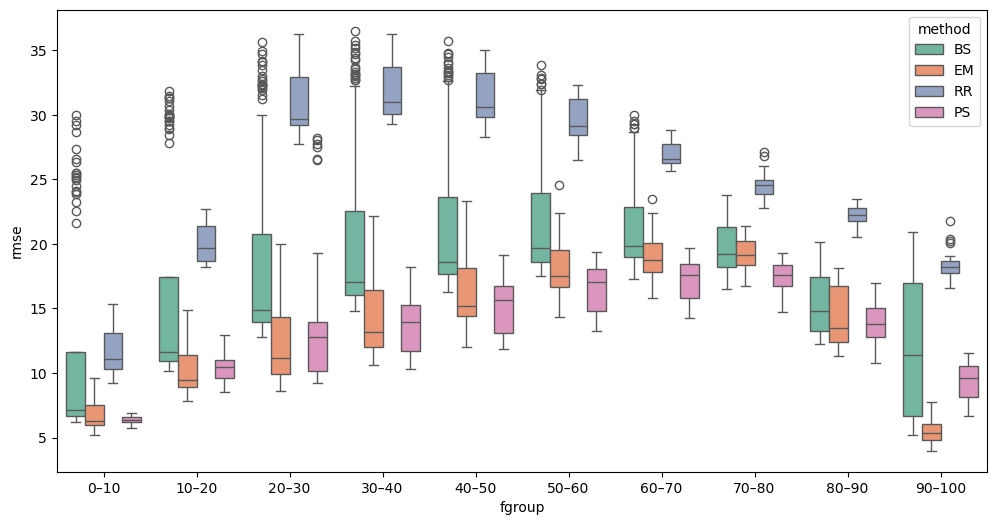

In [3]:
beta_rows = (
    rmse.filter(pl.col('feature') == 'compact_beta_bin')
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .to_pandas())
beta_rows['fgroup'] = pd.Categorical(values=beta_rows['fgroup'],
                                     categories=['0–10', '10–20', '20–30', '30–40',
                                                 '40–50', '50–60', '60–70', '70–80',
                                                 '80–90', '90–100'],
                                     ordered=True)
beta_rows['method'] = pd.Categorical(values=beta_rows['method'],
                                     categories=['BS', 'EM', 'RR', 'PS'],
                                     ordered=True)
fig = plt.figure(figsize=(12, 6))
sns.boxplot(data=beta_rows, x='fgroup', y='rmse', hue='method', palette='Set2')

In [4]:
beta_rows

,lab,sample,feature,fgroup,count,rmse,method
0,BS2,M8_1,compact_beta_bin,60–70,3161157,18.455637,BS
1,EM2,T2_2,compact_beta_bin,40–50,1373259,15.681651,EM
2,EM2,D5_1,compact_beta_bin,90–100,36380,5.862073,EM
3,BS2,M8_2,compact_beta_bin,0–10,2467185,6.346909,BS
4,BS1,T2_1,compact_beta_bin,10–20,2375412,11.467687,BS
...,...,...,...,...,...,...,...
2395,BS3,T1_2,compact_beta_bin,90–100,30103,7.066476,BS
2396,BS3,BL_1,compact_beta_bin,40–50,2710905,18.552790,BS
2397,BS3,T3_2,compact_beta_bin,90–100,29524,7.200322,BS
2398,BS1,T1_2,compact_beta_bin,50–60,1686184,20.005437,BS


In [5]:
(rmse.filter(pl.col('feature') == 'compact_beta_bin')
     .unique(subset=['lab', 'sample', 'fgroup'])
     .rename({'fgroup': 'Beta Bins (%)',
              'rmse': 'RMSE'})
     .drop('feature')
     .write_csv((data_dir / '2_detailed_beta_values' / 'beta_rows.csv')))

In [6]:
beta_rows_wide = (
    rmse.filter(pl.col('feature') == 'compact_beta_bin')
        .unique(subset=['lab', 'sample', 'fgroup']).pivot(
    on='fgroup', values='rmse',
    index=['lab', 'sample']
))

beta_bins: list[str] = ['0–10', '10–20', '20–30', '30–40', '40–50',
                        '50–60', '60–70', '70–80', '80–90', '90–100']

beta_test_results = analyze_tool_performance(
        data=beta_rows_wide.to_pandas(),
        tool_cols=beta_bins,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(beta_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1589.47, p=0.000000, W=0.736

工具平均秩:
  Item  Mean Rank Group
  0–10   1.675000     a
90–100   1.787500     a
 10–20   3.179167     b
 80–90   4.845833     c
 20–30   5.208333     c
 30–40   6.316667     d
 40–50   7.308333     e
 70–80   7.995833     e
 50–60   8.141667     e
 60–70   8.541667     e

优劣顺序（从优到劣）: ['0–10', '90–100', '10–20', '80–90', '20–30', '30–40', '40–50', '70–80', '50–60', '60–70']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
  Item  Mean Rank Group
  0–10   1.675000     a
90–100   1.787500     a
 10–20   3.179167     b
 80–90   4.845833     c
 20–30   5.208333     c
 30–40   6.316667     d
 40–50   7.308333     e
 70–80   7.995833     e
 50–60   8.141667     e
 60–70   8.541667     e

===== 最终工具优劣顺序报告 =====
1. 最优工具: 0–10 (平均秩=1.68, 组=a)
2. 90–100 (平均秩=1.79, 组=a): 与 0–10 无显著差异 (p=1.0000)
3. 10–20 (平均秩=3.18, 组=b): 显著差于 90–100 (p=0.0000)
4. 80–90 (平均秩=4.85, 组=c): 显著差于 10–20 (p=0.0000)
5. 20–30 (平均秩=5.21, 组=c): 与 80–90 无显著差异

# Depth bin

<Axes: xlabel='fgroup', ylabel='rmse'>

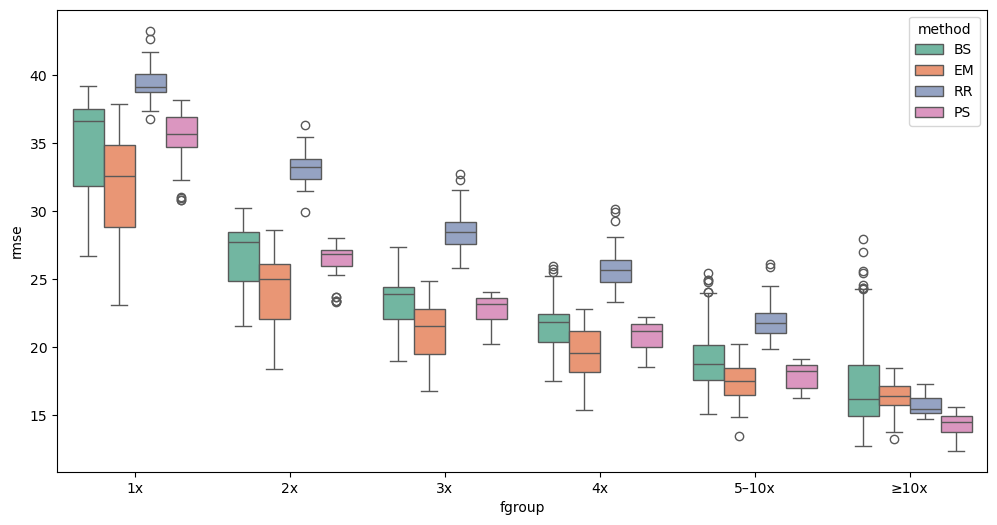

In [7]:
depth_rows: pl.DataFrame = (rmse.filter(pl.col('feature') == 'compact_depth_bin')
                                .unique(subset=['lab', 'sample', 'fgroup'])
                                .with_columns(pl.col('lab').str.head(n=2).alias('method'))
                                .to_pandas())
depth_rows['fgroup'] = pd.Categorical(values=depth_rows['fgroup'],
                                     categories=['1x', '2x', '3x', '4x', '5–10x', '≥10x'],
                                     ordered=True)
depth_rows['method'] = pd.Categorical(values=depth_rows['method'],
                                     categories=['BS', 'EM', 'RR', 'PS'],
                                     ordered=True)

fig = plt.figure(figsize=(12, 6))
sns.boxplot(data=depth_rows, x='fgroup', y='rmse', hue='method', palette='Set2')

In [29]:
(rmse.filter(pl.col('feature') == 'compact_depth_bin')
     .unique(subset=['lab', 'sample', 'fgroup'])
     .rename({'fgroup': 'Depth Bins (x)',
              'rmse': 'RMSE'})
     .drop('feature')
     .write_csv((data_dir / '3_detailed_depth' / 'depth_rows.csv')))

In [8]:
depth_rows_wide = (
    rmse.filter(pl.col('feature') == 'compact_depth_bin')
        .unique(subset=['lab', 'sample', 'fgroup'])
        .pivot(on='fgroup', values='rmse',
               index=['lab', 'sample']
))

depth_bins: list[str] = ['1x', '2x', '3x', '4x', '5–10x', '≥10x']
depth_test_results = analyze_tool_performance(
        data=depth_rows_wide.to_pandas(),
        tool_cols=depth_bins,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(depth_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1179.74, p=0.000000, W=0.983

工具平均秩:
 Item  Mean Rank Group
 ≥10x   1.116667     a
5–10x   1.916667     b
   4x   2.975000     c
   3x   3.991667     d
   2x   5.000000     e
   1x   6.000000     f

优劣顺序（从优到劣）: ['≥10x', '5–10x', '4x', '3x', '2x', '1x']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
 Item  Mean Rank Group
 ≥10x   1.116667     a
5–10x   1.916667     b
   4x   2.975000     c
   3x   3.991667     d
   2x   5.000000     e
   1x   6.000000     f

===== 最终工具优劣顺序报告 =====
1. 最优工具: ≥10x (平均秩=1.12, 组=a)
2. 5–10x (平均秩=1.92, 组=b): 显著差于 ≥10x (p=0.0000)
3. 4x (平均秩=2.98, 组=c): 显著差于 5–10x (p=0.0000)
4. 3x (平均秩=3.99, 组=d): 显著差于 4x (p=0.0000)
5. 2x (平均秩=5.00, 组=e): 显著差于 3x (p=0.0000)
6. 1x (平均秩=6.00, 组=f): 显著差于 2x (p=0.0000)


In [ ]:
results_df.to_csv(data_dir / '3_detailed_depth' / 'posthoc_nemenyi_friedman_depth.csv',
                  index=False)

# beta + depth

In [9]:
beta_depth_rows = (
    rmse.filter(pl.col('feature') == 'compact_depth_bin:compact_beta_bin')
        .unique(subset=['lab', 'sample', 'feature', 'fgroup'])
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=2).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Depth Bin (x)', 'field_1': 'Beta Bin (%)'})
        .drop('feature', 'fgroup')
)

beta_depth_rows

lab,sample,count,rmse,Depth Bin (x),Beta Bin (%)
str,str,i64,f64,str,str
"""RR1""","""D5_1""",372119,33.293791,"""1x""","""70–80"""
"""BS4""","""M8_2""",688921,27.006727,"""5–10x""","""0–10"""
"""EM3""","""M8_1""",2829,18.498666,"""2x""","""10–20"""
"""BS4""","""BC_2""",11712,13.554527,"""4x""","""90–100"""
"""PS3""","""M8_1""",195,24.151814,"""3x""","""20–30"""
…,…,…,…,…,…
"""EM1""","""T3_2""",54187,27.89114,"""3x""","""60–70"""
"""EM1""","""D6_1""",145,22.891891,"""1x""","""80–90"""
"""PS3""","""BL_1""",3834,20.37608,"""3x""","""10–20"""


In [104]:
beta_depth_rows.write_csv(data_dir / '3_detailed_depth' / 'beta_depth_rows.csv')

In [10]:
beta_depth_wide = (
    beta_depth_rows.pivot(on='Depth Bin (x)', values='rmse',
                          index=['lab', 'sample', 'Beta Bin (%)'])
                   .drop_nulls()
)
depth_bins: list[str] = ['1x', '2x', '3x', '4x', '5–10x', '≥10x']

depth_beta_test_results = analyze_tool_performance(
        data=beta_depth_wide.to_pandas(),
        tool_cols=depth_bins,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(depth_beta_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=10769.84, p=0.000000, W=0.915

工具平均秩:
 Item  Mean Rank Group
 ≥10x   1.118471     a
5–10x   2.036518     b
   4x   3.025902     c
   3x   3.991083     d
   2x   4.966879     e
   1x   5.861146     f

优劣顺序（从优到劣）: ['≥10x', '5–10x', '4x', '3x', '2x', '1x']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
 Item  Mean Rank Group
 ≥10x   1.118471     a
5–10x   2.036518     b
   4x   3.025902     c
   3x   3.991083     d
   2x   4.966879     e
   1x   5.861146     f

===== 最终工具优劣顺序报告 =====
1. 最优工具: ≥10x (平均秩=1.12, 组=a)
2. 5–10x (平均秩=2.04, 组=b): 显著差于 ≥10x (p=0.0000)
3. 4x (平均秩=3.03, 组=c): 显著差于 5–10x (p=0.0000)
4. 3x (平均秩=3.99, 组=d): 显著差于 4x (p=0.0000)
5. 2x (平均秩=4.97, 组=e): 显著差于 3x (p=0.0000)
6. 1x (平均秩=5.86, 组=f): 显著差于 2x (p=0.0000)


<Axes: xlabel='beta', ylabel='rmse'>

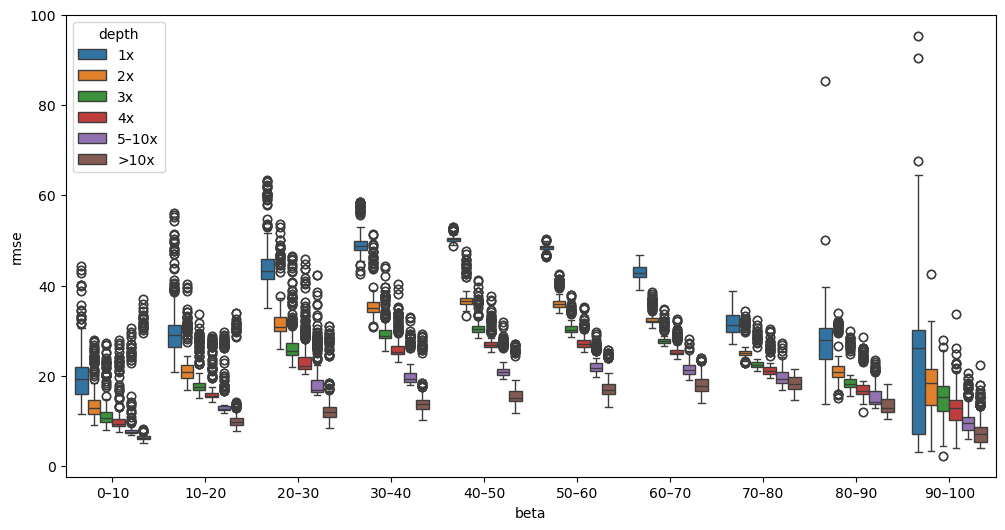

In [31]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(data=beta_depth_rows, x='beta', y='rmse', hue='depth')

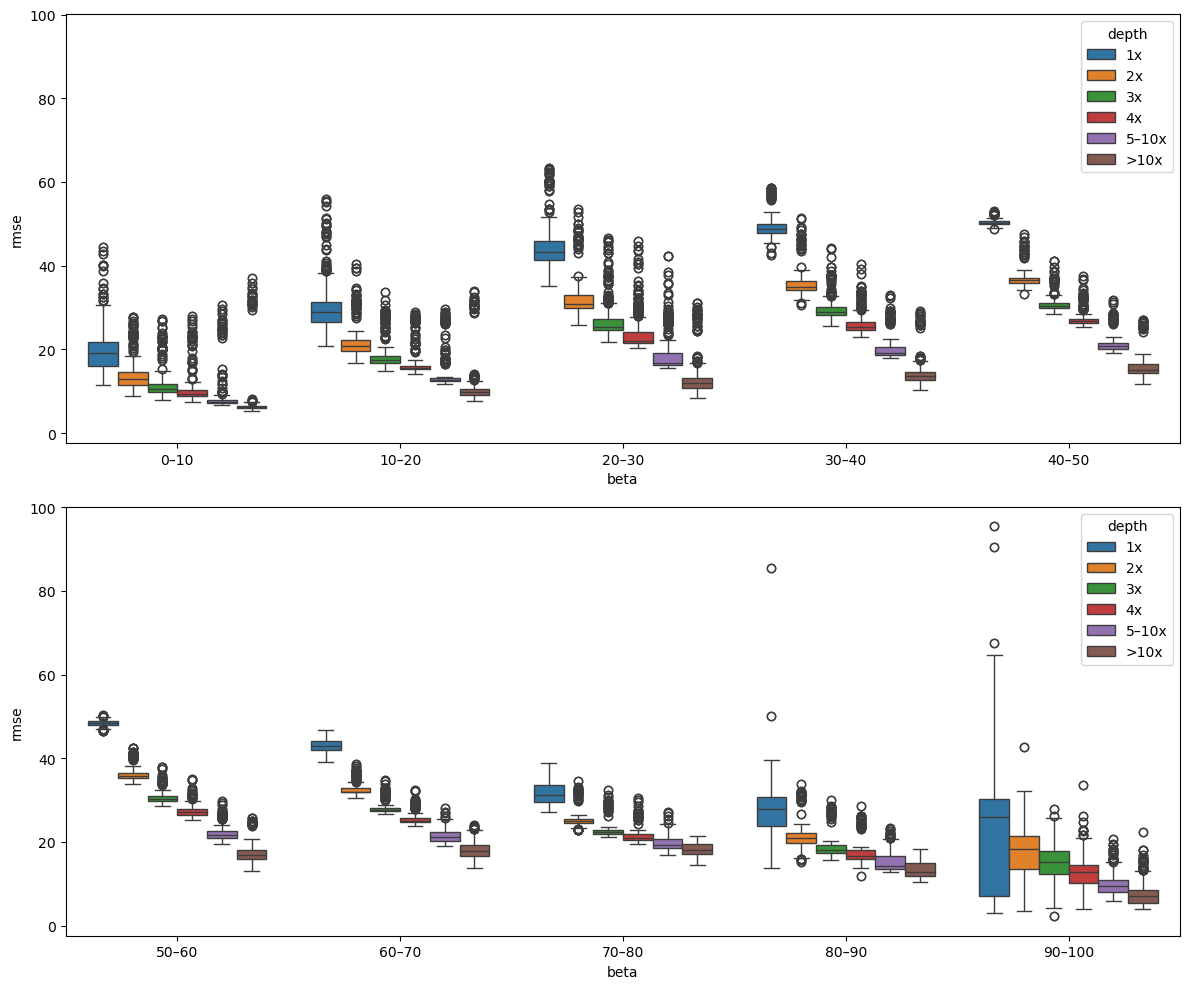

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharey=True)
axes = axes.flatten()
beta_bins1: list[str] = ['0–10', '10–20', '20–30', '30–40', '40–50']
beta_bins2: list[str] = ['50–60', '60–70', '70–80', '80–90', '90–100']

sns.boxplot(data=beta_depth_rows.filter(pl.col('beta').is_in(beta_bins1)),
            x='beta', y='rmse', hue='depth', ax=axes[0])
sns.boxplot(data=beta_depth_rows.filter(pl.col('beta').is_in(beta_bins2)),
            x='beta', y='rmse', hue='depth', ax=axes[1])

plt.tight_layout()

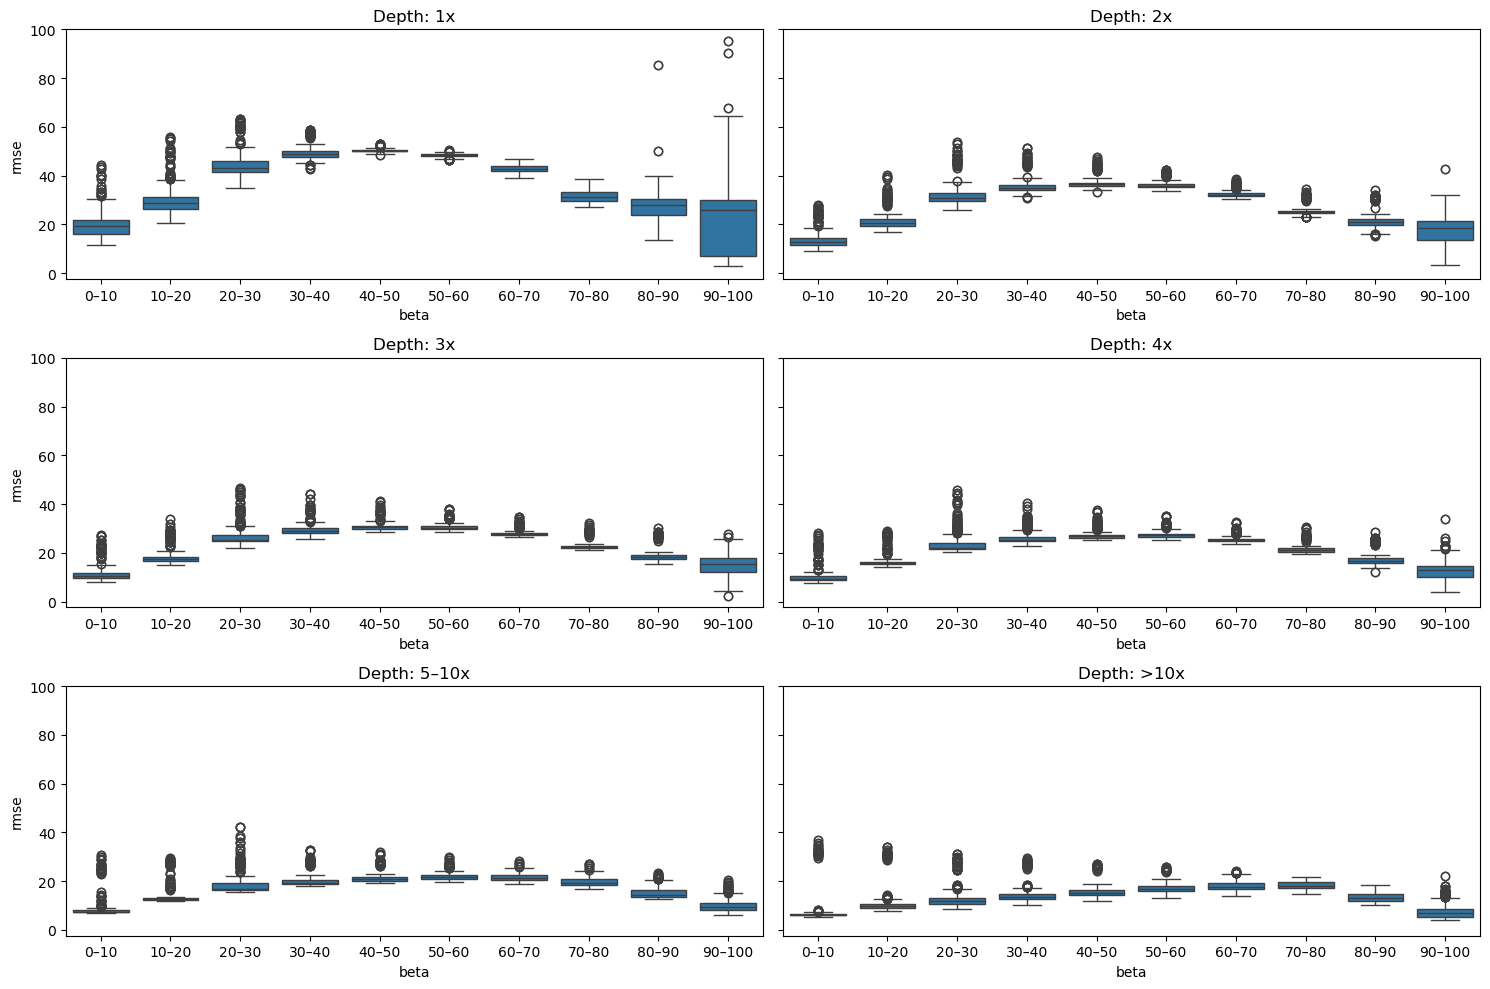

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), sharey=True)
axes = axes.flatten()
depth_bins = ['1x', '2x', '3x', '4x', '5–10x', '>10x']

for i, depth in enumerate(depth_bins):
    sns.boxplot(data=beta_depth_rows.filter(pl.col('depth') == depth).to_pandas(),
                x='beta', y='rmse', ax=axes[i])
    axes[i].set_title(f'Depth: {depth}')

plt.tight_layout()

In [37]:
(beta_depth_rows.rename({'depth': 'Depth Bin (x)',
                         'beta': 'Beta Bin (%)'})
                .drop('feature', 'fgroup')
                .with_columns(pl.col('Depth Bin (x)').str.replace(pattern='>', value='≥'))
                .write_csv(data_dir / 'beta_depth_bins.csv'))

# Cpg Density

In [ ]:
cpg_density_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('cpg'),
                pl.col('fgroup').str.contains('>10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'CpG Density'})
        .with_columns(pl.col('CpG Density').replace(old=['cpg_island', 'cpg_shore',
                                                         'cpg_shelve', 'cpg_inter'],
                                                    new=['CpG Islands', 'CpG Shores',
                                                         'CpG Shelves', 'Open Sea']))
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
cpg_density_rows

lab,sample,count,rmse,method,Beta Bin (%),CpG Density
str,str,i64,f64,str,str,str
"""EM4""","""F7_1""",2702,4.933476,"""EM""","""90–100""","""CpG Shores"""
"""BS2""","""T4_1""",125321,18.689078,"""BS""","""60–70""","""CpG Shelves"""
"""BS3""","""T1_1""",176327,10.360266,"""BS""","""10–20""","""CpG Islands"""
"""EM4""","""F7_1""",3156,4.884772,"""EM""","""90–100""","""CpG Shelves"""
"""BS2""","""BL_2""",29849,16.224816,"""BS""","""30–40""","""CpG Islands"""
…,…,…,…,…,…,…
"""BS2""","""D5_2""",1606928,6.086883,"""BS""","""0–10""","""Open Sea"""
"""PS3""","""T3_1""",5813,10.576878,"""PS""","""80–90""","""CpG Shelves"""
"""PS3""","""F7_1""",1401647,10.884539,"""PS""","""30–40""","""Open Sea"""


In [34]:
(cpg_density_rows.write_csv(data_dir / '4_detailed_cpg_density' / 'cpg_density.csv'))

In [22]:
cpg_rows_wide = (
    rmse.filter(pl.col('feature').str.contains('cpg'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'CpG Density'})
        .with_columns(pl.col('CpG Density').replace(old=['cpg_island', 'cpg_shore',
                                                         'cpg_shelve', 'cpg_inter'],
                                                    new=['CpG Islands', 'CpG Shores',
                                                         'CpG Shelves', 'Open Sea']))
        .pivot(on='CpG Density', values='rmse',
               index=['lab', 'sample', 'Beta Bin (%)'])
        .drop_nulls())

cpg_densities: list[str] = ['CpG Islands', 'CpG Shores', 'CpG Shelves', 'Open Sea']

cpg_density_results = analyze_tool_performance(
        data=cpg_rows_wide.to_pandas(),
        tool_cols=cpg_densities,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(cpg_density_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=459.31, p=0.000000, W=0.069

工具平均秩:
       Item  Mean Rank Group
   Open Sea   2.068089     a
 CpG Shores   2.487517     b
CpG Shelves   2.546074     b
CpG Islands   2.898320     c

优劣顺序（从优到劣）: ['Open Sea', 'CpG Shores', 'CpG Shelves', 'CpG Islands']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
       Item  Mean Rank Group
   Open Sea   2.068089     a
 CpG Shores   2.487517     b
CpG Shelves   2.546074     b
CpG Islands   2.898320     c

===== 最终工具优劣顺序报告 =====
1. 最优工具: Open Sea (平均秩=2.07, 组=a)
2. CpG Shores (平均秩=2.49, 组=b): 显著差于 Open Sea (p=0.0000)
3. CpG Shelves (平均秩=2.55, 组=b): 与 CpG Shores 无显著差异 (p=0.4342)
4. CpG Islands (平均秩=2.90, 组=c): 显著差于 CpG Shelves (p=0.0000)


<Figure size 1200x1000 with 0 Axes>

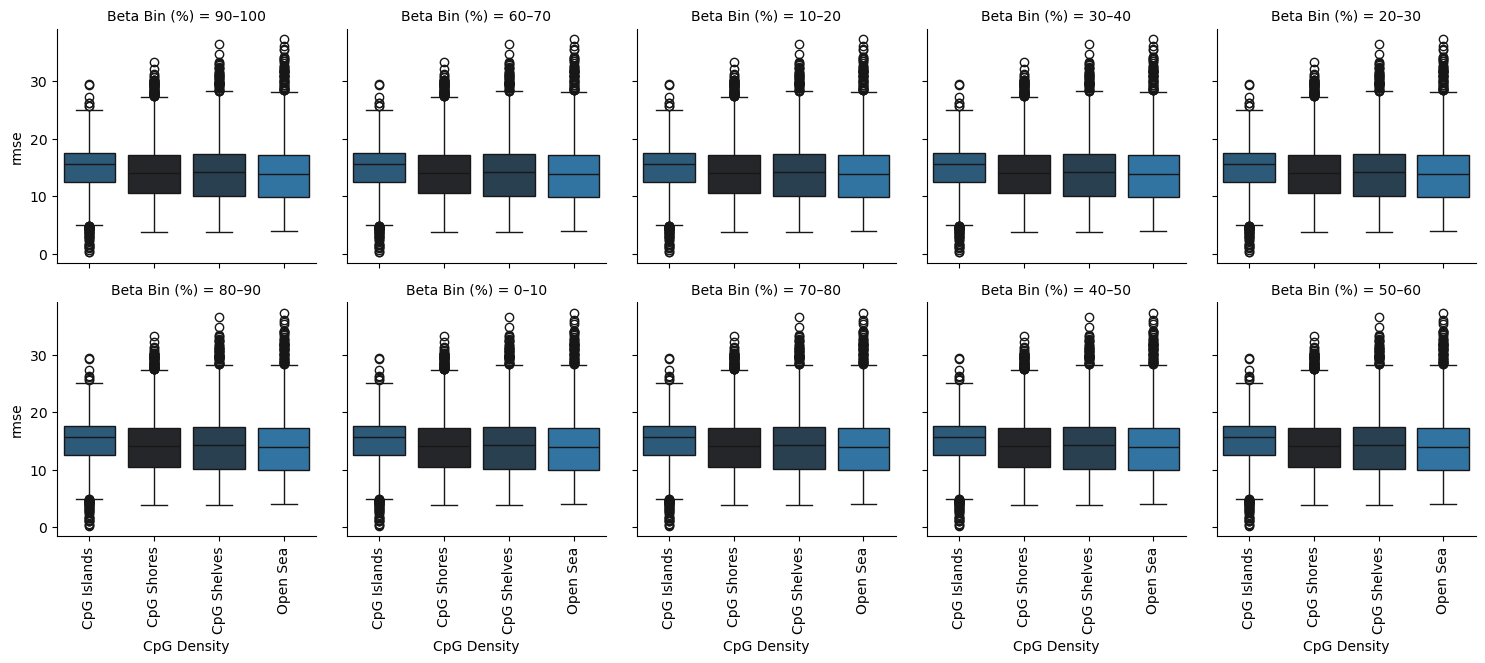

In [ ]:
beta_bins: list[str] = ['0–10', '10–20', '20–30', '30–40',
                        '40–50', '50–60', '60–70', '70–80',
                        '80–90', '90–100']

fig = plt.figure(figsize=(12, 10))
g = sns.FacetGrid(data=cpg_density_rows.to_pandas(),
                  col='Beta Bin (%)', col_wrap=5)
g.map(sns.boxplot, data=cpg_density_rows.to_pandas(),
      x='CpG Density', y='rmse', hue='CpG Density',
      order=['CpG Islands', 'CpG Shores', 'CpG Shelves', 'Open Sea'],
      )
g.set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)

<Axes: xlabel='CpG Density', ylabel='rmse'>

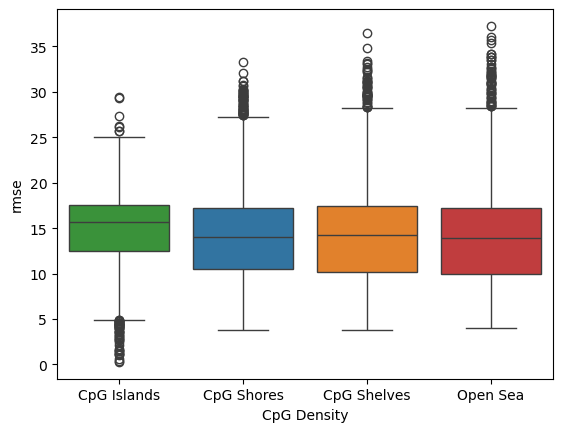

In [57]:
sns.boxplot(data=cpg_density_rows.to_pandas(),
            order=['CpG Islands', 'CpG Shores', 'CpG Shelves', 'Open Sea'],
            x='CpG Density', y='rmse', hue='CpG Density')

# Motif

In [12]:
(
    rmse.filter(pl.col('feature').str.contains_any(['b5', 'b4', 'b3', 'b2', 'b1',
                                                    'a2', 'a3', 'a4', 'a5']),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'feature', 'fgroup'])
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .with_columns(pl.col('feature').str.tail(n=2).alias('Base Location'))
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'Base'})
        ['Base'].unique().sort().to_list())

['', 'A', 'C', 'G', 'N', 'T']

In [23]:
motif_rows_wide = (
    rmse.filter(pl.col('feature').str.contains_any(['b5', 'b4', 'b3', 'b2', 'b1',
                                                    'a2', 'a3', 'a4', 'a5']),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'feature', 'fgroup'])
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .with_columns(pl.col('feature').str.tail(n=2).alias('Base Location'))
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'Base'})
        .filter(pl.col('Base').is_in({'A', 'C', 'T', 'G'}))
        .pivot(on='Base', values='rmse',
               index=['lab', 'sample', 'Base Location', 'Beta Bin (%)'])
        .drop_nulls(subset=['A', 'C', 'T', 'G']))

bases: list[str] = ['A', 'C', 'T', 'G']

motif_test_results = analyze_tool_performance(
        data=motif_rows_wide.to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(motif_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=3285.39, p=0.000000, W=0.053

工具平均秩:
Item  Mean Rank Group
   T   2.247299     a
   A   2.249796     a
   G   2.680672     b
   C   2.822233     c

优劣顺序（从优到劣）: ['T', 'A', 'G', 'C']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   T   2.247299     a
   A   2.249796     a
   G   2.680672     b
   C   2.822233     c

===== 最终工具优劣顺序报告 =====
1. 最优工具: T (平均秩=2.25, 组=a)
2. A (平均秩=2.25, 组=a): 与 T 无显著差异 (p=0.9973)
3. G (平均秩=2.68, 组=b): 显著差于 A (p=0.0000)
4. C (平均秩=2.82, 组=c): 显著差于 G (p=0.0000)


In [25]:
# ! b1
base_location = 'b1'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1736.04, p=0.000000, W=0.268

工具平均秩:
Item  Mean Rank Group
   A   1.630556     a
   T   2.357870     b
   G   2.844907     c
   C   3.166667     d

优劣顺序（从优到劣）: ['A', 'T', 'G', 'C']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   A   1.630556     a
   T   2.357870     b
   G   2.844907     c
   C   3.166667     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: A (平均秩=1.63, 组=a)
2. T (平均秩=2.36, 组=b): 显著差于 A (p=0.0000)
3. G (平均秩=2.84, 组=c): 显著差于 T (p=0.0000)
4. C (平均秩=3.17, 组=d): 显著差于 G (p=0.0000)


In [26]:
# ! b2
base_location = 'b2'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=733.54, p=0.000000, W=0.111

工具平均秩:
Item  Mean Rank Group
   A   1.933697     a
   T   2.487738     b
   G   2.606267     c
   C   2.972298     d

优劣顺序（从优到劣）: ['A', 'T', 'G', 'C']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   A   1.933697     a
   T   2.487738     b
   G   2.606267     c
   C   2.972298     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: A (平均秩=1.93, 组=a)
2. T (平均秩=2.49, 组=b): 显著差于 A (p=0.0000)
3. G (平均秩=2.61, 组=c): 显著差于 T (p=0.0124)
4. C (平均秩=2.97, 组=d): 显著差于 G (p=0.0000)


In [27]:
# ! b3
base_location = 'b3'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=441.00, p=0.000000, W=0.061

工具平均秩:
Item  Mean Rank Group
   T   2.205417     a
   G   2.242917     a
   C   2.751250     b
   A   2.800417     b

优劣顺序（从优到劣）: ['T', 'G', 'C', 'A']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   T   2.205417     a
   G   2.242917     a
   C   2.751250     b
   A   2.800417     b

===== 最终工具优劣顺序报告 =====
1. 最优工具: T (平均秩=2.21, 组=a)
2. G (平均秩=2.24, 组=a): 与 T 无显著差异 (p=0.7458)
3. C (平均秩=2.75, 组=b): 显著差于 G (p=0.0000)
4. A (平均秩=2.80, 组=b): 与 C 无显著差异 (p=0.5506)


In [25]:
# ! b4
base_location = 'b4'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=135.30, p=0.000000, W=0.021

工具平均秩:
Item  Mean Rank Group
   G   2.353704     a
   T   2.364815     a
   A   2.528704     b
   C   2.752778     c

优劣顺序（从优到劣）: ['G', 'T', 'A', 'C']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   G   2.353704     a
   T   2.364815     a
   A   2.528704     b
   C   2.752778     c

===== 最终工具优劣顺序报告 =====
1. 最优工具: G (平均秩=2.35, 组=a)
2. T (平均秩=2.36, 组=a): 与 G 无显著差异 (p=0.9921)
3. A (平均秩=2.53, 组=b): 显著差于 T (p=0.0002)
4. C (平均秩=2.75, 组=c): 显著差于 A (p=0.0000)


In [26]:
# ! b5
base_location = 'b5'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=749.16, p=0.000000, W=0.105

工具平均秩:
Item  Mean Rank Group
   A   2.024759     a
   T   2.294167     b
   G   2.731431     c
   C   2.949643     d

优劣顺序（从优到劣）: ['A', 'T', 'G', 'C']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   A   2.024759     a
   T   2.294167     b
   G   2.731431     c
   C   2.949643     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: A (平均秩=2.02, 组=a)
2. T (平均秩=2.29, 组=b): 显著差于 A (p=0.0000)
3. G (平均秩=2.73, 组=c): 显著差于 T (p=0.0000)
4. C (平均秩=2.95, 组=d): 显著差于 G (p=0.0000)


In [28]:
# ! a2
base_location = 'a2'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1277.74, p=0.000000, W=0.178

工具平均秩:
Item  Mean Rank Group
   T   1.979472     a
   A   2.120235     b
   C   2.760788     c
   G   3.139506     d

优劣顺序（从优到劣）: ['T', 'A', 'C', 'G']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   T   1.979472     a
   A   2.120235     b
   C   2.760788     c
   G   3.139506     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: T (平均秩=1.98, 组=a)
2. A (平均秩=2.12, 组=b): 显著差于 T (p=0.0010)
3. C (平均秩=2.76, 组=c): 显著差于 A (p=0.0000)
4. G (平均秩=3.14, 组=d): 显著差于 C (p=0.0000)


In [29]:
# ! a3
base_location = 'a3'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=357.54, p=0.000000, W=0.050

工具平均秩:
Item  Mean Rank Group
   A   2.172500     a
   T   2.376667     b
   C   2.615417     c
   G   2.835417     d

优劣顺序（从优到劣）: ['A', 'T', 'C', 'G']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   A   2.172500     a
   T   2.376667     b
   C   2.615417     c
   G   2.835417     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: A (平均秩=2.17, 组=a)
2. T (平均秩=2.38, 组=b): 显著差于 A (p=0.0000)
3. C (平均秩=2.62, 组=c): 显著差于 T (p=0.0000)
4. G (平均秩=2.84, 组=d): 显著差于 C (p=0.0000)


In [27]:
# ! a4
base_location = 'a4'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1069.79, p=0.000000, W=0.151

工具平均秩:
Item  Mean Rank Group
   T   1.780374     a
   G   2.545455     b
   C   2.765506     c
   A   2.908666     d

优劣顺序（从优到劣）: ['T', 'G', 'C', 'A']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   T   1.780374     a
   G   2.545455     b
   C   2.765506     c
   A   2.908666     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: T (平均秩=1.78, 组=a)
2. G (平均秩=2.55, 组=b): 显著差于 T (p=0.0000)
3. C (平均秩=2.77, 组=c): 显著差于 G (p=0.0000)
4. A (平均秩=2.91, 组=d): 显著差于 C (p=0.0008)


In [28]:
# ! a5
base_location = 'a5'
base_test_results = analyze_tool_performance(
        data=motif_rows_wide.filter(pl.col('Base Location') == base_location).to_pandas(),
        tool_cols=bases,
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=458.31, p=0.000000, W=0.064

工具平均秩:
Item  Mean Rank Group
   A   2.077343     a
   T   2.413199     b
   C   2.704077     c
   G   2.805380     d

优劣顺序（从优到劣）: ['A', 'T', 'C', 'G']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
Item  Mean Rank Group
   A   2.077343     a
   T   2.413199     b
   C   2.704077     c
   G   2.805380     d

===== 最终工具优劣顺序报告 =====
1. 最优工具: A (平均秩=2.08, 组=a)
2. T (平均秩=2.41, 组=b): 显著差于 A (p=0.0000)
3. C (平均秩=2.70, 组=c): 显著差于 T (p=0.0000)
4. G (平均秩=2.81, 组=d): 显著差于 C (p=0.0344)


In [34]:
motif_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains_any(['b5', 'b4', 'b3', 'b2', 'b1',
                                                    'a2', 'a3', 'a4', 'a5']),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'feature', 'fgroup'])
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .with_columns(pl.col('feature').str.tail(n=2).alias('Base Location'))
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'Base'})
        .drop('Depth Bin (x)', 'feature', 'fgroup')
        .filter(pl.col('Base') != '')
        .select('lab', 'sample', 'Beta Bin (%)', 'Base Location', 'Base', 'count', 'rmse')
        .sort(by=['lab', 'sample', 'Beta Bin (%)',  'Base Location', 'Base'])
    )
motif_rows

lab,sample,Beta Bin (%),Base Location,Base,count,rmse
str,str,str,str,str,i64,f64
"""BS1""","""BC_1""","""0–10""","""a2""","""A""",286308,6.115567
"""BS1""","""BC_1""","""0–10""","""a2""","""C""",153625,5.861405
"""BS1""","""BC_1""","""0–10""","""a2""","""G""",250489,5.959303
"""BS1""","""BC_1""","""0–10""","""a2""","""T""",336604,6.115368
"""BS1""","""BC_1""","""0–10""","""a3""","""A""",198703,6.043755
…,…,…,…,…,…,…
"""RR1""","""T4_2""","""90–100""","""b4""","""C""",2681,9.199045
"""RR1""","""T4_2""","""90–100""","""b4""","""T""",7,21.387697
"""RR1""","""T4_2""","""90–100""","""b5""","""A""",474,6.853269


In [35]:
motif_rows.write_csv(data_dir / '5_detailed_motif' / 'motif_rows.csv')

<Figure size 1200x1000 with 0 Axes>

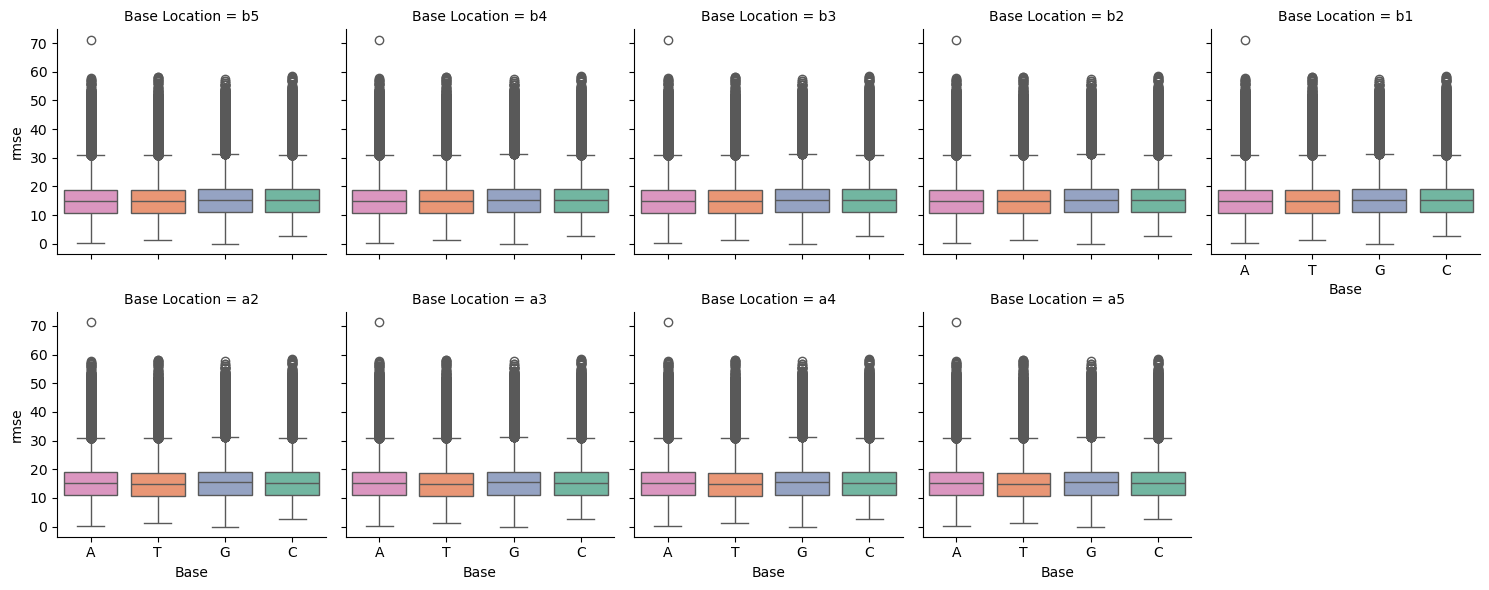

In [ ]:
fig = plt.figure(figsize=(12, 10))
g = sns.FacetGrid(data=motif_rows.to_pandas(),
                  col='Base Location', col_wrap=5,
                  col_order=['b5', 'b4', 'b3', 'b2', 'b1',
                             'a5', 'a4', 'a3', 'a2'])
g.map(sns.boxplot, data=motif_rows.to_pandas(),
      x='Base', y='rmse', order=['A', 'T', 'G', 'C'],
      hue='Base', palette='Set2')

<Figure size 1200x1000 with 0 Axes>

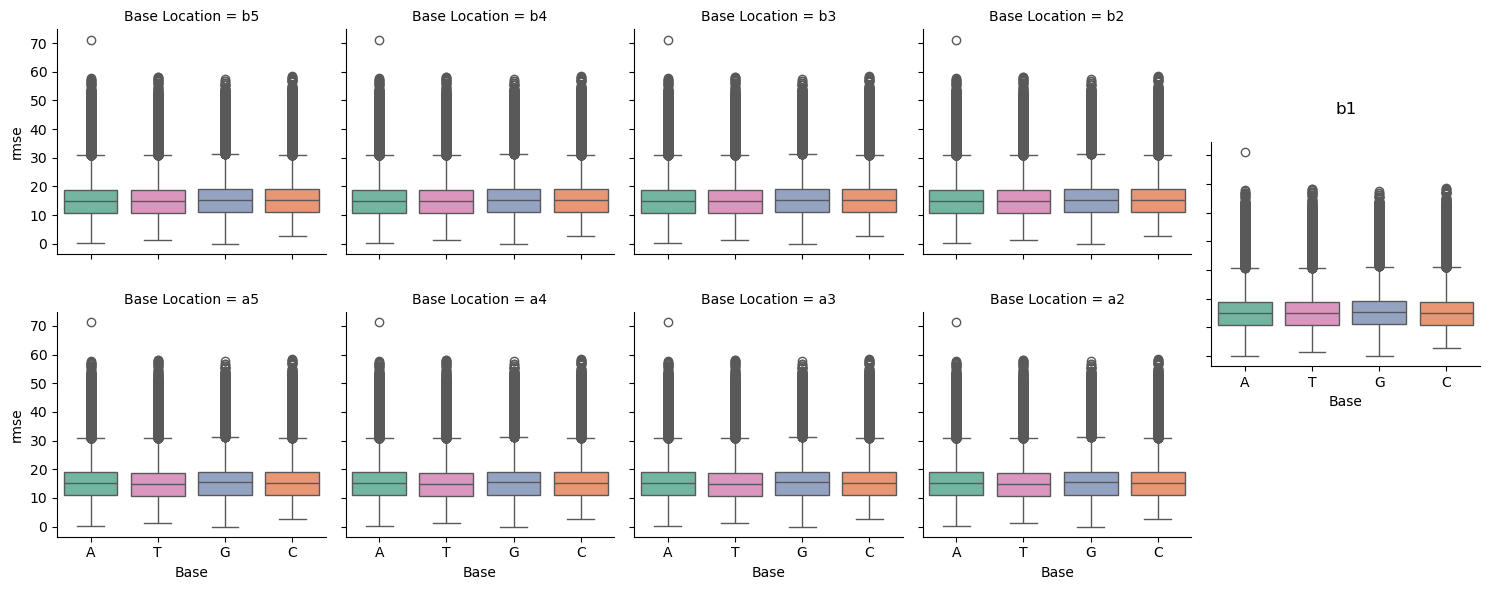

In [39]:
fig = plt.figure(figsize=(12, 10))
g = sns.FacetGrid(
    data=motif_rows.to_pandas(),
    col='Base Location',
    col_wrap=5,
    col_order=['b5', 'b4', 'b3', 'b2', 'b1',
               'a5', 'a4', 'a3', 'a2'],
    sharey=True  # 可选：共享 Y 轴
)

# 绘制所有子图
g.map(sns.boxplot, data=motif_rows.to_pandas(),
      x='Base', y='rmse', order=['A', 'T', 'G', 'C'],
      hue='Base', palette='Set2')

# 找到 b1 对应的 axes
# b1 是 col_order 中的第5个（索引4）
b1_ax = g.axes[4]  # 因为 g.axes 是按顺序排列的

# 获取当前位置
pos = b1_ax.get_position()

# 下移半个行高
# 假设每行高度约为 (pos.y1 - pos.y0)
row_height = pos.height
dy = row_height * 0.5  # 下移半个单元格

# 修改位置：y0 和 y1 都下移
new_pos = [pos.x0, pos.y0 - dy, pos.width, pos.height]
b1_ax.set_position(new_pos)

# 可选：调整标题位置，避免重叠
b1_ax.set_title('b1', pad=20)

plt.show()

# GC Bin

In [15]:
gc_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('gc_bin'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'GC Bin (%)'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
gc_rows

lab,sample,count,rmse,method,Beta Bin (%),GC Bin (%)
str,str,i64,f64,str,str,str
"""BS4""","""T2_1""",12932,20.744064,"""BS""","""30–40""","""50–60"""
"""PS1""","""D5_2""",98490,18.020669,"""PS""","""60–70""","""20–30"""
"""PS2""","""D6_2""",23861,11.669738,"""PS""","""80–90""","""50–60"""
"""EM3""","""T1_1""",43274,11.541309,"""EM""","""10–20""","""70–80"""
"""RR1""","""T2_1""",12664,8.649472,"""RR""","""0–10""","""40–50"""
…,…,…,…,…,…,…
"""BS1""","""D5_2""",156622,12.532023,"""BS""","""20–30""","""50–60"""
"""EM4""","""T3_2""",71794,6.374181,"""EM""","""0–10""","""70–80"""
"""PS3""","""BL_2""",16,15.684557,"""PS""","""70–80""","""0–10"""


In [16]:
gc_wide: pl.DataFrame = (
    gc_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='GC Bin (%)', values='rmse')
)

base_test_results = analyze_tool_performance(
        data=gc_wide.drop_nulls().to_pandas(),
        tool_cols=[f'{i}–{i + 10}' for i in range(0, 100, 10)],
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(base_test_results)



===== 工具性能分析摘要 =====
Friedman检验: χ²=21.04, p=0.012479, W=0.167

工具平均秩:
  Item  Mean Rank Group
 30–40   3.714286     a
 40–50   3.857143     a
 20–30   4.357143     a
 50–60   4.928571     a
 60–70   5.571429     a
90–100   5.928571     a
 70–80   6.357143     a
  0–10   6.357143     a
 10–20   6.571429     a
 80–90   7.357143     a

优劣顺序（从优到劣）: ['30–40', '40–50', '20–30', '50–60', '60–70', '90–100', '70–80', '0–10', '10–20', '80–90']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
  Item  Mean Rank Group
 30–40   3.714286     a
 40–50   3.857143     a
 20–30   4.357143     a
 50–60   4.928571     a
 60–70   5.571429     a
90–100   5.928571     a
 70–80   6.357143     a
  0–10   6.357143     a
 10–20   6.571429     a
 80–90   7.357143     a

===== 最终工具优劣顺序报告 =====
1. 最优工具: 30–40 (平均秩=3.71, 组=a)
2. 40–50 (平均秩=3.86, 组=a): 与 30–40 无显著差异 (p=1.0000)
3. 20–30 (平均秩=4.36, 组=a): 与 40–50 无显著差异 (p=1.0000)
4. 50–60 (平均秩=4.93, 组=a): 与 20–30 无显著差异 (p=1.0000)
5. 60–70 (平均秩=5.57, 组=a): 与 50–60 无

<Figure size 1200x1000 with 0 Axes>

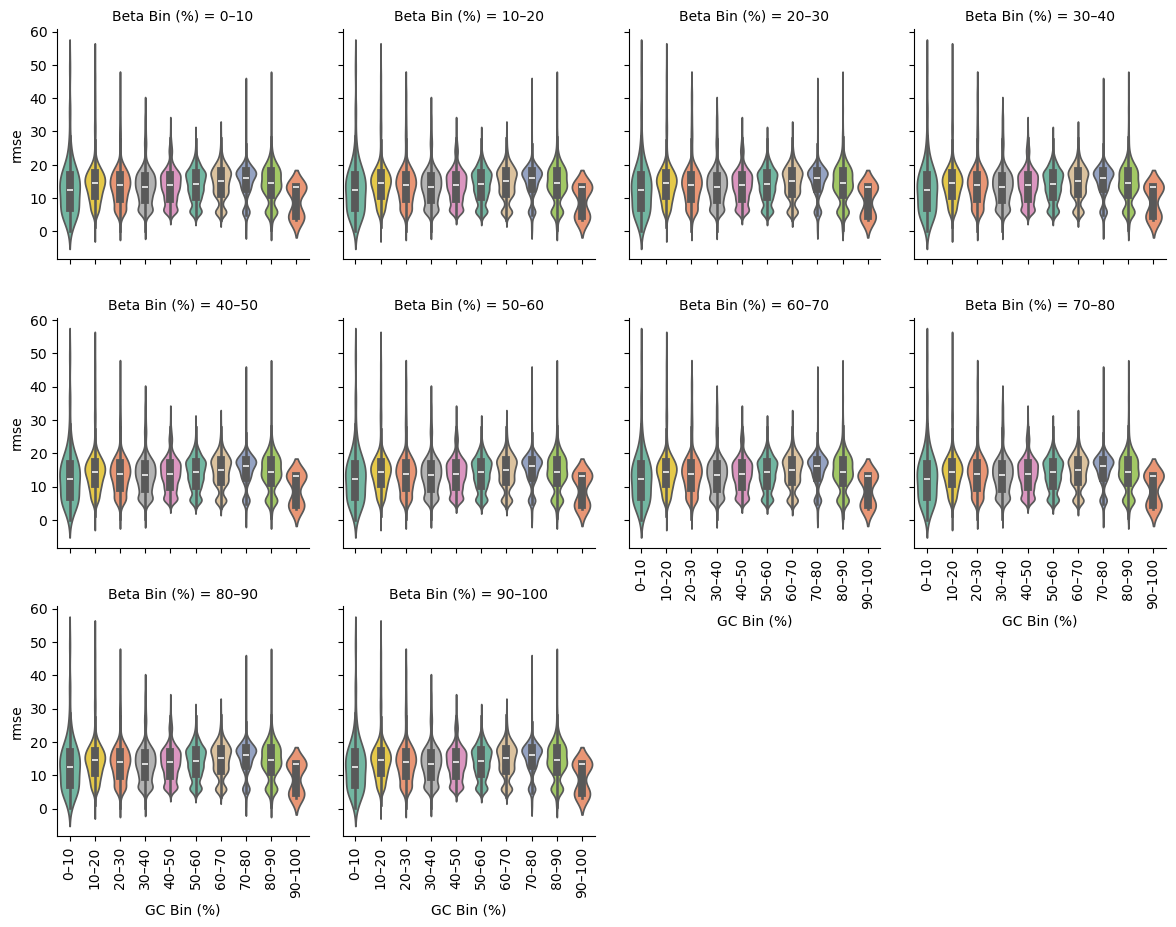

In [17]:
fig = plt.figure(figsize=(12, 10))
g = sns.FacetGrid(
    data=gc_rows.to_pandas(),
    col='Beta Bin (%)',
    col_wrap=4,
    col_order=[f'{i}–{i + 10}' for i in range(0, 100, 10)],
    sharey=True  # 可选：共享 Y 轴
)

# 绘制所有子图
g.map(sns.violinplot, data=gc_rows.to_pandas(),
      x='GC Bin (%)', y='rmse', order=[f'{i}–{i + 10}' for i in range(0, 100, 10)],
      hue='GC Bin (%)', palette='Set2')

g.set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)

In [12]:
gc_rows.write_csv(data_dir / '6_detailed_seq_features' / '1_gc_content' / 'gc_rows.csv')

In [11]:
all_feature_dir: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/feature_importance')

old_names: list[str] = [
    'CpG_GC_ratio_70', 'GC%_70', 'GC_skew_70', 'ShannonEntropy_70', 'BWT_ratio_70',
    'b1', 'b2', 'b3', 'b4', 'b5', 'a2', 'a3', 'a4', 'a5',
    'cpg', 'depth', 'enhancer', 'location', 'promoter', 'modification_type']
new_names: list[str] = [
    'CpG / GC', 'GC%', 'GC skew', 'Shannon Entropy', 'BWT Compression Ratio',
    'b1', 'b2', 'b3', 'b4', 'b5', 'a2', 'a3', 'a4', 'a5',
    'CpG Density', 'Sequencing Depth', 'Enhancer', 'Genetic Location',
    'Promoter', 'Methylation Type']
feature_mapping: dict[str, str] = {
    'CpG / GC': 'detailed GC content',
    'GC%': 'detailed GC content',
    'GC skew': 'detailed GC content',
    'Shannon Entropy': 'sequence complexity',
    'BWT Compression Ratio': 'sequence complexity',
    'b1': 'motif', 'b2': 'motif', 'b3': 'motif', 'b4': 'motif', 'b5': 'motif',
    'a2': 'motif', 'a3': 'motif', 'a4': 'motif', 'a5': 'motif',
    'CpG Density': 'CpG density', 'Sequencing Depth': 'sequencing depth',
    'Enhancer': 'genomic locations', 'Genetic Location': 'genomic locations',
    'Promoter': 'genomic locations', 'Methylation Type': 'methylation type'
}

group_order: list[str] = ['sequencing depth', 'methylation type', 'CpG density',
               'detailed GC content', 'sequence complexity',
               'motif', 'genomic locations']

p_values  = (pl.concat([pl.scan_csv(f, skip_rows=1, has_header=False,
                                          schema={'feature': pl.String, 'importance': pl.Float64,
                                                  'stddev': pl.Float64, 'p_value': pl.Float64,
                                                  'n': pl.Int64, 'p99_high': pl.Float64,
                                                  'p99_low': pl.Float64})
                                .with_columns(pl.lit(f.parent.name.split('_')[0]).alias('lab'),
                                              pl.lit(f.parent.name.split('_')[1]).alias('label'),
                                              pl.lit(f.parent.name.split('_')[2]).alias('rep'),
                                              pl.lit(f.parent.name).alias('sample'))
                                .select('lab', 'label', 'rep', 'sample', 'feature', 'p_value')
                                for f in all_feature_dir.rglob('feature_importance_context_70bp.csv')
                                if '10k_sample' not in f.parent.name and 'RR' not in f.name])
                        .with_columns(pl.col('feature')
                                        .replace(old=old_names, new=new_names)
                                        .alias('feature'))
                        .filter(pl.col('feature').is_in({'b5', 'b4', 'b3', 'b2', 'b1',
                                                         'a2', 'a3', 'a4', 'a5'}))
                        .collect())
p_values

lab,label,rep,sample,feature,p_value
str,str,str,str,str,f64
"""BS1""","""BC""","""1""","""BS1_BC_1""","""b1""",0.000007
"""BS1""","""BC""","""1""","""BS1_BC_1""","""b4""",0.000705
"""BS1""","""BC""","""1""","""BS1_BC_1""","""a3""",0.00003
"""BS1""","""BC""","""1""","""BS1_BC_1""","""a4""",0.000218
"""BS1""","""BC""","""1""","""BS1_BC_1""","""a2""",0.000186
…,…,…,…,…,…
"""PS2""","""D5""","""1""","""PS2_D5_1""","""a4""",0.000134
"""PS2""","""D5""","""1""","""PS2_D5_1""","""b3""",0.000005
"""PS2""","""D5""","""1""","""PS2_D5_1""","""a5""",0.000799


In [13]:
mean_p_values: pl.DataFrame = (p_values.group_by('feature')
                                       .agg(pl.col('p_value')
                                              .mean()
                                              .alias('mean_p_value'))
                                       .sort('feature'))
mean_p_values

feature,mean_p_value
str,f64
"""a2""",0.000416
"""a3""",0.000363
"""a4""",0.000212
"""a5""",0.000281
"""b1""",0.000154
"""b2""",0.000281
"""b3""",0.000313
"""b4""",0.000298
"""b5""",0.000812


# CpG / GC ratio

In [18]:
cpg_gc_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('cpg_prop'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'Cpg Prop Bin (%)'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
cpg_gc_rows

lab,sample,count,rmse,method,Beta Bin (%),Cpg Prop Bin (%)
str,str,i64,f64,str,str,str
"""EM3""","""T4_2""",241,11.265967,"""EM""","""20–30""","""0.3–0.32"""
"""PS3""","""F7_2""",508012,14.646213,"""PS""","""70–80""","""0.06–0.08"""
"""EM2""","""D6_2""",415196,8.389085,"""EM""","""10–20""","""0.1–0.12"""
"""RR1""","""T3_2""",1368,7.765559,"""RR""","""90–100""","""0.18–0.2"""
"""BS1""","""M8_1""",425846,14.518389,"""BS""","""80–90""","""0.12–0.14"""
…,…,…,…,…,…,…
"""BS3""","""T3_2""",4861,11.427054,"""BS""","""20–30""","""0.24–0.26"""
"""EM4""","""D6_2""",206608,5.900651,"""EM""","""0–10""","""0.1–0.12"""
"""EM4""","""T4_1""",23,11.087234,"""EM""","""80–90""","""0.04–0.06"""


In [21]:
cpg_gc_wide: pl.DataFrame = (
    cpg_gc_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='Cpg Prop Bin (%)', values='rmse')
)

cpg_gc_test_results = analyze_tool_performance(
        data=cpg_gc_wide.drop_nulls().to_pandas(),
        tool_cols=cpg_gc_rows['Cpg Prop Bin (%)'].unique().sort().to_list(),
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(cpg_gc_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=292.71, p=0.000000, W=0.029

工具平均秩:
     Item  Mean Rank Group
 0.0–0.02   8.953815     a
0.02–0.04   9.550201     a
 0.4–0.42   9.819277     a
0.04–0.06  10.281124     a
0.06–0.08  10.359438     a
0.14–0.16  10.465863     a
 0.08–0.1  10.536145     a
0.12–0.14  10.578313     a
0.16–0.18  10.636546     a
 0.1–0.12  10.732932     a
 0.18–0.2  10.793173     a
 0.2–0.22  10.861446     a
0.22–0.24  10.979920     a
0.24–0.26  11.200803     a
0.36–0.38  11.449799     a
0.26–0.28  11.632530     a
 0.38–0.4  11.648594     a
 0.28–0.3  11.732932     a
 0.3–0.32  12.582329     a
0.34–0.36  12.847390     a
0.32–0.34  13.357430     a

优劣顺序（从优到劣）: ['0.0–0.02', '0.02–0.04', '0.4–0.42', '0.04–0.06', '0.06–0.08', '0.14–0.16', '0.08–0.1', '0.12–0.14', '0.16–0.18', '0.1–0.12', '0.18–0.2', '0.2–0.22', '0.22–0.24', '0.24–0.26', '0.36–0.38', '0.26–0.28', '0.38–0.4', '0.28–0.3', '0.3–0.32', '0.34–0.36', '0.32–0.34']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
  

# GC skew

In [23]:
gc_skew_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('gc_skew'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'GC skew Bin'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
gc_skew_rows

lab,sample,count,rmse,method,Beta Bin (%),GC skew Bin
str,str,i64,f64,str,str,str
"""EM3""","""M8_1""",330161,13.308474,"""EM""","""40–50""","""0.1 – 0.2"""
"""BS3""","""T2_1""",108,19.002073,"""BS""","""60–70""","""0.7 – 0.8"""
"""RR1""","""T1_2""",83,16.352664,"""RR""","""60–70""","""-0.6 – -0.5"""
"""BS1""","""BL_2""",6504,14.113844,"""BS""","""30–40""","""0.5 – 0.6"""
"""BS3""","""BL_1""",429,16.344315,"""BS""","""50–60""","""-0.7 – -0.6"""
…,…,…,…,…,…,…
"""BS2""","""D6_1""",405361,12.606008,"""BS""","""30–40""","""0.0 – 0.1"""
"""EM3""","""F7_1""",26,15.149848,"""EM""","""50–60""","""0.8 – 0.9"""
"""EM3""","""M8_2""",5231,10.847274,"""EM""","""30–40""","""-0.6 – -0.5"""


In [26]:
gc_skew_wide: pl.DataFrame = (
    gc_skew_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='GC skew Bin', values='rmse')
)

gc_skew_test_results = analyze_tool_performance(
        data=gc_skew_wide.drop_nulls().to_pandas(),
        tool_cols=gc_skew_rows['GC skew Bin'].unique().sort().to_list(),
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(gc_skew_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1422.55, p=0.000000, W=0.053

工具平均秩:
       Item  Mean Rank Group
-0.8 – -0.7   7.882188     a
-0.7 – -0.6   8.455119     a
  0.9 – 1.0   8.970547     a
-1.0 – -0.9   9.126227     a
-0.9 – -0.8   9.405330     a
  0.8 – 0.9   9.761571     a
-0.6 – -0.5   9.879383     a
-0.2 – -0.1   9.939691     a
 -0.1 – 0.0  10.215288     a
-0.3 – -0.2  10.350631     a
  0.7 – 0.8  10.732819     a
-0.5 – -0.4  10.927069     a
-0.4 – -0.3  11.082749     a
  0.6 – 0.7  11.123422     a
  0.0 – 0.1  11.416550     a
  0.4 – 0.5  11.471950     a
  0.3 – 0.4  11.713184     a
  0.5 – 0.6  11.850631     a
  0.2 – 0.3  12.709677     b
  0.1 – 0.2  12.985975     b

优劣顺序（从优到劣）: ['-0.8 – -0.7', '-0.7 – -0.6', '0.9 – 1.0', '-1.0 – -0.9', '-0.9 – -0.8', '0.8 – 0.9', '-0.6 – -0.5', '-0.2 – -0.1', '-0.1 – 0.0', '-0.3 – -0.2', '0.7 – 0.8', '-0.5 – -0.4', '-0.4 – -0.3', '0.6 – 0.7', '0.0 – 0.1', '0.4 – 0.5', '0.3 – 0.4', '0.5 – 0.6', '0.2 – 0.3', '0.1 – 0.2']

Friedman检验显著 (p<0.05)，存

# ShannonEntropy

In [13]:
se_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('se_bin'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'SE Bin'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
se_rows

lab,sample,count,rmse,method,Beta Bin (%),SE Bin
str,str,i64,f64,str,str,str
"""EM4""","""T1_2""",356701,15.973802,"""EM""","""40–50""","""low"""
"""EM4""","""F7_1""",451522,14.040494,"""EM""","""40–50""","""low"""
"""EM1""","""T2_2""",267160,9.691977,"""EM""","""10–20""","""medium"""
"""RR1""","""T2_2""",71093,7.688323,"""RR""","""0–10""","""medium"""
"""BS2""","""T1_1""",1001,5.697072,"""BS""","""90–100""","""low"""
…,…,…,…,…,…,…
"""EM1""","""T4_1""",4742,6.198959,"""EM""","""90–100""","""medium"""
"""EM1""","""F7_1""",426946,17.761077,"""EM""","""50–60""","""low"""
"""PS3""","""BL_1""",228170,14.381992,"""PS""","""50–60""","""high"""


In [14]:
se_wide: pl.DataFrame = (
    se_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='SE Bin', values='rmse')
)

se_test_results = analyze_tool_performance(
        data=se_wide.drop_nulls().to_pandas(),
        tool_cols=['low', 'medium', 'high', 'very_high'],
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(se_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=208.76, p=0.000000, W=0.032

工具平均秩:
     Item  Mean Rank Group
very_high   2.272222     a
      low   2.332407     a
   medium   2.659259     b
     high   2.736111     b

优劣顺序（从优到劣）: ['very_high', 'low', 'medium', 'high']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
     Item  Mean Rank Group
very_high   2.272222     a
      low   2.332407     a
   medium   2.659259     b
     high   2.736111     b

===== 最终工具优劣顺序报告 =====
1. 最优工具: very_high (平均秩=2.27, 组=a)
2. low (平均秩=2.33, 组=a): 与 very_high 无显著差异 (p=0.4182)
3. medium (平均秩=2.66, 组=b): 显著差于 low (p=0.0000)
4. high (平均秩=2.74, 组=b): 与 medium 无显著差异 (p=0.2048)


<Figure size 1200x1000 with 0 Axes>

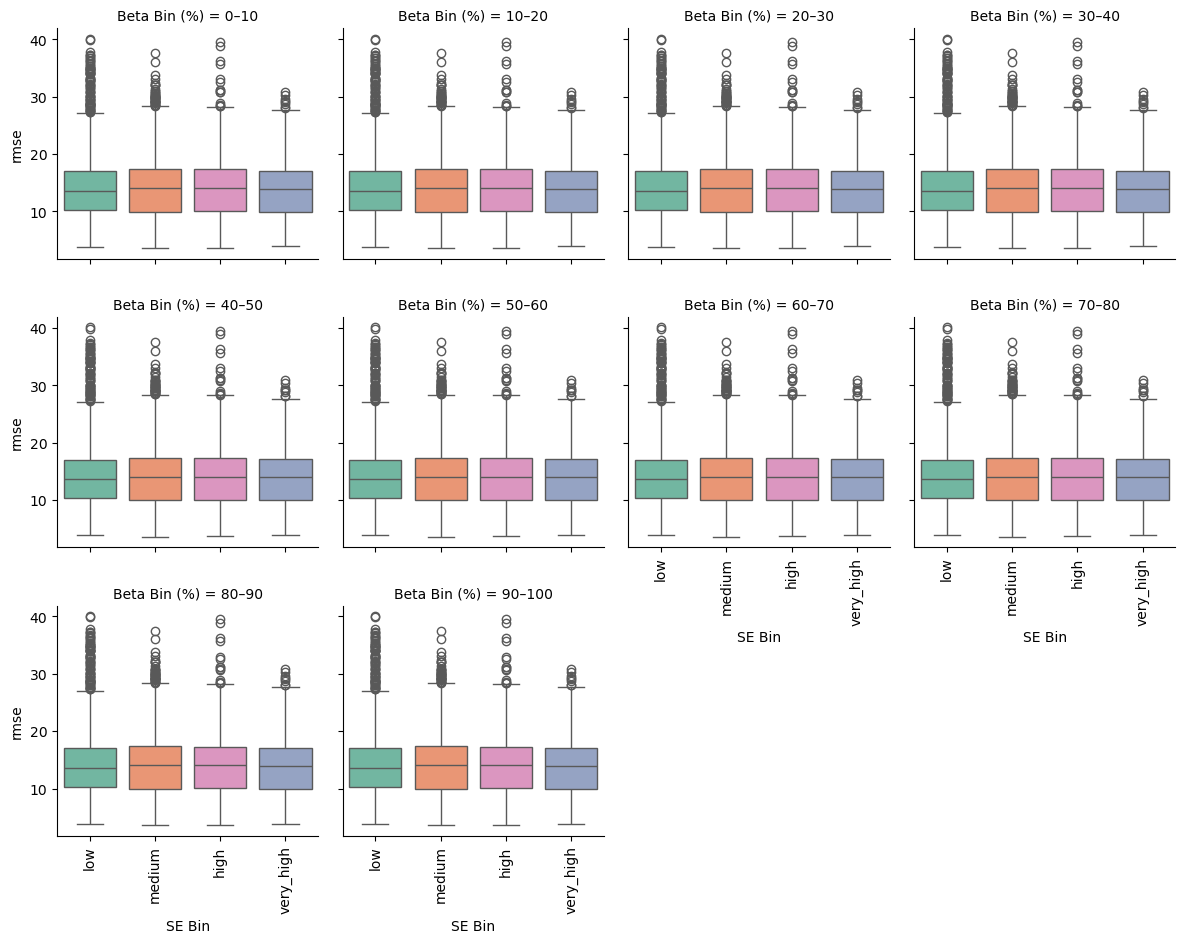

In [21]:
fig = plt.figure(figsize=(12, 10))
g = sns.FacetGrid(
    data=se_rows.to_pandas(),
    col='Beta Bin (%)',
    col_wrap=4,
    col_order=[f'{i}–{i + 10}' for i in range(0, 100, 10)],
    sharey=True  # 可选：共享 Y 轴
)

# 绘制所有子图
g.map(sns.boxplot, data=se_rows.to_pandas(),
      x='SE Bin', y='rmse', order=['low', 'medium', 'high', 'very_high'],
      hue='SE Bin', palette='Set2')

g.set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)

In [22]:
se_rows.write_csv(data_dir / '6_detailed_seq_features' / '2_seq_complexity' / 'shannon_entropy_rows.csv')

# BWT Ratio

In [23]:
bwt_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('bwt_bin'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'BWT Bin'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
bwt_rows

lab,sample,count,rmse,method,Beta Bin (%),BWT Bin
str,str,i64,f64,str,str,str
"""EM1""","""BL_1""",9644,6.332718,"""EM""","""90–100""","""medium"""
"""RR1""","""T2_2""",15291,18.219072,"""RR""","""50–60""","""high"""
"""EM1""","""T4_2""",13189,12.799583,"""EM""","""80–90""","""high"""
"""BS2""","""BC_2""",4934655,17.148742,"""BS""","""80–90""","""high"""
"""PS1""","""T2_1""",450512,15.883103,"""PS""","""50–60""","""very_high"""
…,…,…,…,…,…,…
"""EM2""","""BC_1""",4590582,17.002658,"""EM""","""80–90""","""medium"""
"""RR1""","""F7_2""",255068,17.667615,"""RR""","""70–80""","""medium"""
"""PS2""","""T2_1""",16048,11.243943,"""PS""","""80–90""","""low"""


In [24]:
bwt_wide: pl.DataFrame = (
    bwt_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='BWT Bin', values='rmse')
)

bwt_test_results = analyze_tool_performance(
        data=bwt_wide.drop_nulls().to_pandas(),
        tool_cols=['low', 'medium', 'high', 'very_high'],
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(bwt_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=19.33, p=0.000233, W=0.003

工具平均秩:
     Item  Mean Rank Group
     high   2.443333     a
      low   2.446250     a
   medium   2.530417     a
very_high   2.580000     a

优劣顺序（从优到劣）: ['high', 'low', 'medium', 'very_high']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
     Item  Mean Rank Group
     high   2.443333     a
      low   2.446250     a
   medium   2.530417     a
very_high   2.580000     a

===== 最终工具优劣顺序报告 =====
1. 最优工具: high (平均秩=2.44, 组=a)
2. low (平均秩=2.45, 组=a): 与 high 无显著差异 (p=0.9998)
3. medium (平均秩=2.53, 组=a): 与 low 无显著差异 (p=0.1079)
4. very_high (平均秩=2.58, 组=a): 与 medium 无显著差异 (p=0.5434)


In [25]:
bwt_rows.write_csv(data_dir / '6_detailed_seq_features' / '2_seq_complexity' / 'bwt_ratio_rows.csv')

In [27]:
ref_dir: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/quartet_reference/single_c/ensembl/final/full_seq_info')
labels: list[str] = ['D5', 'D6', 'F7', 'M8', 'BC', 'BL']

ref_df: pl.DataFrame = (
    pl.concat([
        pl.scan_parquet(ref_dir / f'{label}.parquet.lz4')
          .filter(pl.col('in_hcr'))
          .select('chrom', 'start', 'GC%_70', 'GC_skew_70', 'CpG_GC_ratio_70', 'ShannonEntropy_70', 'BWT_ratio_70')
        for label in labels
    ]).collect()
)

distribution_data: dict[str, list[float]] = {}
for seq_feature in ('GC%_70', 'GC_skew_70', 'CpG_GC_ratio_70', 'ShannonEntropy_70', 'BWT_ratio_70'):
    distribution_data[seq_feature] = (ref_df.select('chrom', 'start', seq_feature)
                                            .drop_nulls()
                                            .unique(subset=['chrom', 'start'])
                                            [seq_feature]
                                            .to_list())

In [28]:
import gc
del ref_df
gc.collect()

26808

In [31]:
for feature, values in distribution_data.items():
    (pl.DataFrame({feature: values})
       .write_parquet(data_dir / '6_detailed_seq_features' / f'{feature}_values.parquet.lz4',
                      compression='lz4'))

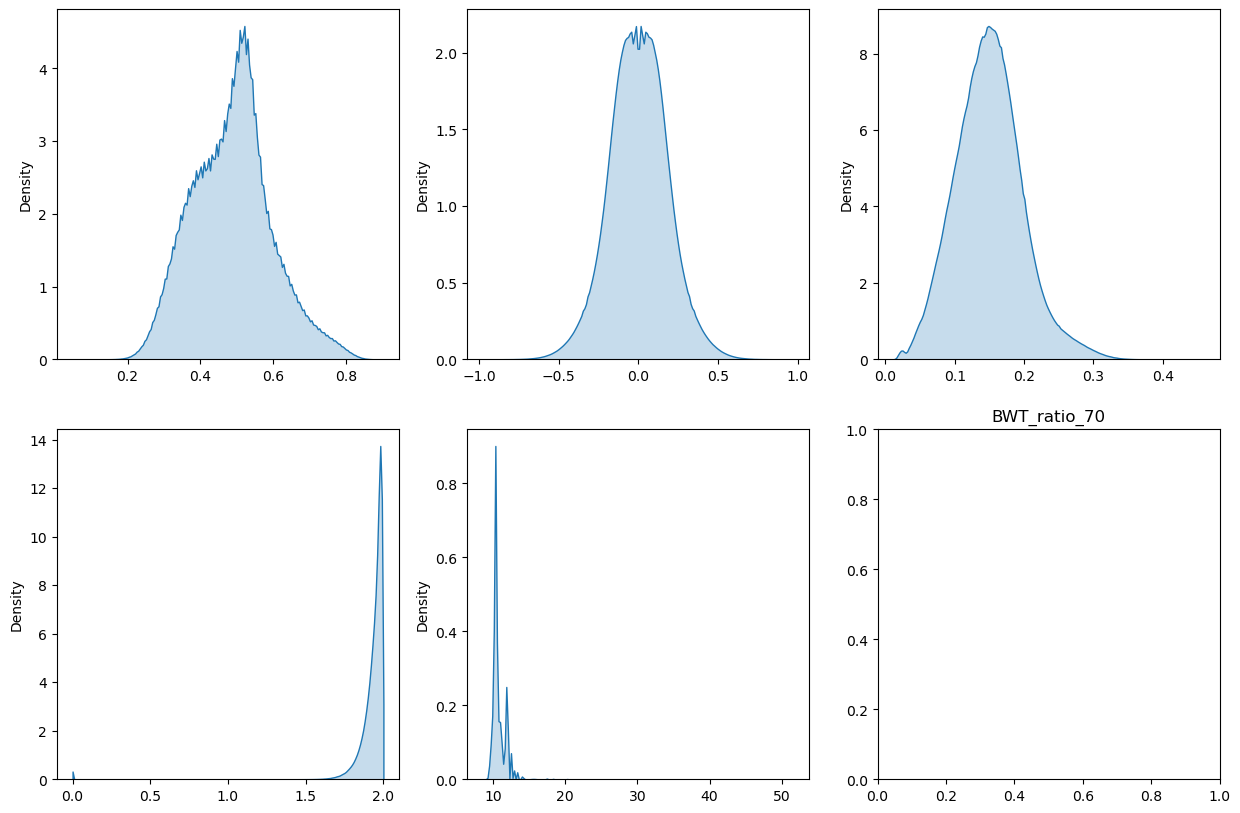

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, (feature, values) in enumerate(distribution_data.items()):
    sns.kdeplot(data=values, ax=axes[i], fill=True, cut=0)
    plt.title(feature)


# Genomic Locations

In [4]:
location_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('location'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'Location'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
location_rows

lab,sample,count,rmse,method,Beta Bin (%),Location
str,str,i64,f64,str,str,str
"""BS3""","""T1_1""",51,10.973941,"""BS""","""80–90""","""exon"""
"""RR1""","""F7_1""",2550,17.010567,"""RR""","""80–90""","""1st_exon"""
"""BS4""","""D6_1""",43861,26.52775,"""BS""","""30–40""","""intergenic"""
"""PS3""","""F7_1""",3440,12.577068,"""PS""","""40–50""","""exon_intron_bound"""
"""BS3""","""M8_2""",17,11.244148,"""BS""","""90–100""","""exon"""
…,…,…,…,…,…,…
"""PS1""","""T2_1""",2356,11.063305,"""PS""","""20–30""","""exon_intron_bound"""
"""EM4""","""T1_2""",7463,16.534627,"""EM""","""40–50""","""intron_exon_bound"""
"""BS2""","""D5_1""",2112,13.475556,"""BS""","""30–40""","""5UTR"""


In [6]:
location_wide: pl.DataFrame = (
    location_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='Location', values='rmse')
)

location_test_results = analyze_tool_performance(
        data=location_wide.drop_nulls().to_pandas(),
        tool_cols=['1st_exon', '3UTR', '5UTR', 'TTS_1to5kb', 'cds', 'exon',
                   'exon_intron_bound', 'intergenic', 'intron', 'intron_exon_bound'],
        better="smaller",  # 指标越小越好
        alpha=0.05,
        output_cd_diagram=False
    )
print_analysis_summary(location_test_results)


===== 工具性能分析摘要 =====
Friedman检验: χ²=1393.10, p=0.000000, W=0.076

工具平均秩:
             Item  Mean Rank Group
       intergenic   4.238446     a
             exon   4.352016     a
           intron   4.641593     a
exon_intron_bound   5.294494     b
         1st_exon   5.659292     c
intron_exon_bound   5.836283     c
       TTS_1to5kb   5.865290     c
              cds   6.202557     d
             3UTR   6.444444     d
             5UTR   6.465585     d

优劣顺序（从优到劣）: ['intergenic', 'exon', 'intron', 'exon_intron_bound', '1st_exon', 'intron_exon_bound', 'TTS_1to5kb', 'cds', '3UTR', '5UTR']

Friedman检验显著 (p<0.05)，存在工具间差异

工具分组结果（字母相同表示无显著差异）:
             Item  Mean Rank Group
       intergenic   4.238446     a
             exon   4.352016     a
           intron   4.641593     a
exon_intron_bound   5.294494     b
         1st_exon   5.659292     c
intron_exon_bound   5.836283     c
       TTS_1to5kb   5.865290     c
              cds   6.202557     d
             3UTR   6.444444     d
 

In [7]:
enhancer_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('enhancer'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'enhancer'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
enhancer_rows

lab,sample,count,rmse,method,Beta Bin (%),enhancer
str,str,i64,f64,str,str,str
"""RR1""","""T4_2""",5,5.044854,"""RR""","""90–100""","""true"""
"""BS4""","""T4_1""",342,26.906321,"""BS""","""30–40""","""true"""
"""BS4""","""T2_2""",976,22.493187,"""BS""","""60–70""","""true"""
"""BS4""","""BL_2""",557209,35.860003,"""BS""","""0–10""","""false"""
"""EM2""","""T4_2""",54,4.428411,"""EM""","""90–100""","""true"""
…,…,…,…,…,…,…
"""PS3""","""T4_2""",2164503,8.887236,"""PS""","""10–20""","""false"""
"""PS1""","""M8_1""",13857,12.308266,"""PS""","""30–40""","""true"""
"""BS3""","""M8_1""",37817,10.612326,"""BS""","""10–20""","""true"""


In [12]:
from typing import Literal


def run_paired_test(true_col: pl.Series,
                    false_col: pl.Series,
                    alpha: float = .05):
    diff: pl.Series = (true_col - false_col).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(false_col, true_col)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        result_type = 't_test'
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(true_col, false_col)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        result_type = 'wilcoxon'

    if p_val < alpha:
        print('✅ There is a significant difference between true_col and false_col treatment (p < 0.05)')
    else:
        print('❌ There is no significant difference between true_col and false_col treatment (p ≥ 0.05)')

    return result_type, diff.median(), p_val

In [14]:
enhancer_wide: pl.DataFrame = (
    enhancer_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='enhancer', values='rmse').drop_nulls()
)

enhancer_test_results = run_paired_test(
    true_col=enhancer_wide['true'],
    false_col=enhancer_wide['false']
)
print(enhancer_test_results)

Shapiro-Wilk Normality Test: W=0.627, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 1354158, p = 3.244e-02
  median diff = 0.017
✅ There is a significant difference between true_col and false_col treatment (p < 0.05)
('wilcoxon', 0.0166643499396244, 0.03244499098339253)


In [15]:
promoter_rows: pl.DataFrame = (
    rmse.filter(pl.col('feature').str.contains('promoter'),
                pl.col('fgroup').str.contains('≥10x'))
        .unique(subset=['lab', 'sample', 'fgroup'])
        .with_columns(pl.col('lab').str.head(n=2).alias('method'))
        .with_columns(pl.col('fgroup').str.splitn(by=':', n=3).alias('tmp'))
        .unnest('tmp')
        .rename({'field_0': 'Beta Bin (%)', 'field_1': 'Depth Bin (x)', 'field_2': 'promoter'})
        .drop('feature', 'fgroup', 'Depth Bin (x)')
    )
promoter_rows

lab,sample,count,rmse,method,Beta Bin (%),promoter
str,str,i64,f64,str,str,str
"""EM1""","""T2_1""",843327,17.475409,"""EM""","""40–50""","""false"""
"""BS3""","""T3_1""",1305607,9.498587,"""BS""","""10–20""","""false"""
"""BS3""","""T1_1""",750,6.510089,"""BS""","""90–100""","""true"""
"""RR1""","""F7_2""",256,7.391926,"""RR""","""90–100""","""true"""
"""PS2""","""T4_2""",23967,15.174617,"""PS""","""40–50""","""true"""
…,…,…,…,…,…,…
"""EM4""","""BC_1""",31195,16.390466,"""EM""","""40–50""","""true"""
"""BS2""","""BL_1""",82477,13.967251,"""BS""","""30–40""","""true"""
"""EM4""","""BL_2""",490317,17.688428,"""EM""","""70–80""","""true"""


In [16]:
promoter_wide: pl.DataFrame = (
    promoter_rows.pivot(index=['lab', 'sample', 'method', 'Beta Bin (%)'], on='promoter', values='rmse').drop_nulls()
)

promoter_test_results = run_paired_test(
    true_col=promoter_wide['true'],
    false_col=promoter_wide['false']
)
print(promoter_test_results)

Shapiro-Wilk Normality Test: W=0.639, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 1071381, p = 1.520e-27
  median diff = 0.119
✅ There is a significant difference between true_col and false_col treatment (p < 0.05)
('wilcoxon', 0.11910706825639128, 1.5195410869745339e-27)
